In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.neural_network as nn
import pickle
from glob import glob
from timeit import default_timer as timer
import sys
from GraphingAndTransfer.extractDataset import *
import scipy.stats as stats

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from tune_sklearn import TuneGridSearchCV

from keras.utils import np_utils,to_categorical
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import optimizers

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [2]:
import sys
import os
import csv
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from matplotlib.widgets import TextBox, Button, RadioButtons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec

from sklearn import preprocessing



# Definitions
BASEPATH = os.getcwd()
# SAVEFOLDER = ''
# TESTFOLDER = ''
# PROCESSEDFOLDER = 'processed/train/'
# PROCESSEDFOLDER = 'processed/test/XY'
DANCEMOVENAMES = ("dab","elbowkick","gun","hair","listen","pointhigh","sidepump","wipetable")
IS_RETURN_DATAFRAME = True

#Changeable Parameters
NUMBER_OF_AFTER_SAMPLES = 3 #Number of samples to include in dance move after end detected
NUMBER_OF_BEFORE_SAMPLES = 5 #Number of samples to include in dance move before start detected
MINIMUM_MOVE_TIME = 25 #Minimum number of samples to be considered a move. Set this too low and you will get garbage dance samples

IS_PAD = True
PAD_NUM =20

USE_MAX_SAMPLES = True
MAX_SAMPLES = 100
USETEMP = True
USEACCEL= True
TEMPORALDATAAUGNUM = 5
NUMRANDOMSHIFTSACCEL = 5
Z_RAND_MAX = 0.05


class rawDataset():
    def __init__(self, device, movename, timestamp, dataset):
        self.device = device
        self.movename = movename
        self.timestamp = timestamp
        self.dataset = dataset
    def plot(self):
        fig = plt.figure()
        gs = gridspec.GridSpec(3, 1, width_ratios=[1], height_ratios=[0.2,1,1])
        index = [ x for x in range(len(self.dataset['activation_List']))]
        # print(index)
        # TODO plot the activation
        activation = fig.add_subplot(gs[0])
        accel = fig.add_subplot(gs[1])
        gyro = fig.add_subplot(gs[2])

        activation.set_title("Device " + str(self.device) + "\nActivation" )
        accel.set_title("Accel" )
        gyro.set_title("Gyro" )


        ax1, = accel.plot(index, self.dataset['a_xList'], label = "X")
        ax2, = accel.plot(index, self.dataset['a_yList'], label = "Y")
        ax3, = accel.plot(index, self.dataset['a_zList'], label = "Z")

        ax4, = gyro.plot(index, self.dataset['g_xList'], label = "X")
        ax5, = gyro.plot(index, self.dataset['g_yList'], label = "Y")
        ax6, = gyro.plot(index, self.dataset['g_zList'], label = "Z")

        ax7, = activation.plot(index, self.dataset['activation_List'], label = "R")
        
        displaylen = len(self.dataset['activation_List'])

        activation.set_xlim(xmin = 0 , xmax = displaylen )
        activation.set_ylim(ymin = 0.2 , ymax = 2.2 )

        accel.set_xlim(xmin = 0 , xmax = displaylen )
        accel.set_ylim(ymin = -2 , ymax = 2 )

        gyro.set_xlim(xmin = 0 , xmax = displaylen )
        gyro.set_ylim(ymin = -250 , ymax = 250 )
        
        plt.show()

    
        plt.clf()


class dancemove():
    def __init__(self, device, movename, timestamp,a_xList,a_yList,a_zList,g_xList,g_yList,g_zList,activation_List ):
        self.device = device
        self.movename = movename
        self.timestamp = timestamp

        self.a_xList = a_xList
        self.a_yList = a_yList
        self.a_zList = a_zList

        self.g_xList = g_xList
        self.g_yList = g_yList
        self.g_zList = g_zList
        
        self.activation_List = activation_List

    def toDict(self):
        d = dict()
        d['movename'] = self.movename
        d['a_xList'] = self.a_xList
        d['a_yList'] = self.a_yList
        d['a_zList'] = self.a_zList
        d['g_xList'] = self.g_xList
        d['g_yList'] = self.g_yList
        d['g_zList'] = self.g_zList
        d['activation_List'] = self.activation_List
        return d

    def writeThisFile(self,moveid):
        fname = "{}_{}_{}_{}".format(self.device, self.movename, self.timestamp, str(moveid))
        f = os.path.join(BASEPATH,PROCESSEDFOLDER,fname ) 
        if not os.path.exists(os.path.dirname(f)):
            try:
                os.makedirs(os.path.dirname(f))
            except OSError as exc: # Guard against race condition
                if exc.errno != errno.EEXIST:
                    raise
        with open(f, 'w', newline='') as csvfile:
            row = [
                    'a_xList',
                    'a_yList',
                    'a_zList',
                    'g_xList',
                    'g_yList',
                    'g_zList',
                    'activation_List'
                ]
            csvWriter = csv.writer(csvfile, delimiter=',')
            csvWriter.writerow(row)
            for idx in range(len(self.a_xList)):
                row = [
                    self.a_xList[idx],
                    self.a_yList[idx],
                    self.a_zList[idx],
                    self.g_xList[idx],
                    self.g_yList[idx],
                    self.g_zList[idx],
                    self.activation_List[idx]
                ] 
                csvWriter.writerow(row)

    def plotNorm(self, show =True):
        fig = plt.figure()
        gs = gridspec.GridSpec(3, 1, width_ratios=[1], height_ratios=[0.2,1,1])
        index = [ x for x in range(len(self.activation_List))]
        # print(index)
        # TODO plot the activation
        activation = fig.add_subplot(gs[0])
        accel = fig.add_subplot(gs[1])
        gyro = fig.add_subplot(gs[2])

        activation.set_title("{} {} {}".format(self.device, self.movename, self.timestamp) )
        accel.set_title("Accel" )
        gyro.set_title("Gyro" )
        # print( self.a_xList)

        d = self.getDataAsNumpyArray( norm = True)
        ax1, = accel.plot(index, d[0], label = "X")
        ax2, = accel.plot(index, d[1], label = "Y")
        ax3, = accel.plot(index, d[2], label = "Z")

        ax4, = gyro.plot(index, d[3], label = "X")
        ax5, = gyro.plot(index, d[4], label = "Y")
        ax6, = gyro.plot(index, d[5], label = "Z")

        ax7, = activation.plot(index, self.activation_List, label = "R")
        

        activation.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        activation.set_ylim(ymin = 0 , ymax = 2.2 )

        accel.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        accel.set_ylim(ymin = 0 , ymax = 1.1 )

        gyro.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        gyro.set_ylim(ymin = 0 , ymax = 1.1 )

        if show:
            plt.show(block = True)
            plt.clf()

    def plot(self, show =True):
        fig = plt.figure()
        gs = gridspec.GridSpec(3, 1, width_ratios=[1], height_ratios=[0.2,1,1])
        index = [ x for x in range(len(self.activation_List))]
        # print(index)
        # TODO plot the activation
        activation = fig.add_subplot(gs[0])
        accel = fig.add_subplot(gs[1])
        gyro = fig.add_subplot(gs[2])

        activation.set_title("{} {} {}".format(self.device, self.movename, self.timestamp) )
        accel.set_title("Accel" )
        gyro.set_title("Gyro" )
        # print( self.a_xList)

        ax1, = accel.plot(index, self.a_xList, label = "X")
        ax2, = accel.plot(index, self.a_yList, label = "Y")
        ax3, = accel.plot(index, self.a_zList, label = "Z")

        ax4, = gyro.plot(index, self.g_xList, label = "X")
        ax5, = gyro.plot(index, self.g_yList, label = "Y")
        ax6, = gyro.plot(index, self.g_zList, label = "Z")

        ax7, = activation.plot(index, self.activation_List, label = "R")
        

        activation.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        activation.set_ylim(ymin = 0.2 , ymax = 2.2 )

        accel.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        accel.set_ylim(ymin = -2 , ymax = 2 )

        gyro.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        gyro.set_ylim(ymin = -250 , ymax = 250 )

        if show:
            plt.show(block = True)
            plt.clf()

    def print_Data(self):
        print(self.activation_List)

    def get_label(self):
        return self.movename

    def get_data(self):
        return [
            self.a_xList,
            self.a_yList,
            self.a_zList,
            self.g_xList,
            self.g_yList,
            self.g_zList,
            self.activation_List
        ] 

    def get_data_len(self):
        mydata = self.get_data()
        assert all(len(x)==len(mydata[0]) for x in mydata)
        return len(mydata[0])

    
    
    def getDataAsNumpyArray(self, norm = True):
            x = np.array(self.a_xList)
            y = np.array(self.a_yList)
            z = np.array(self.a_zList)
            x2 = np.array(self.g_xList)
            y2 = np.array(self.g_yList)
            z2 = np.array(self.g_zList)
            a = np.array(self.activation_List)

            if norm:
                NormLimit = 1
                x = (x+2)/4 * NormLimit
                y = (y+2)/4 * NormLimit
                z = (z+2)/4 * NormLimit

                x2 = (x2+250)/ (250 * 2) * NormLimit
                y2 = (y2+250)/ (250 * 2) * NormLimit
                z2 = (z2+250)/ (250 * 2) * NormLimit

                x = np.clip(x,0,NormLimit)
                y = np.clip(y,0,NormLimit)
                z = np.clip(z,0,NormLimit)

                x2 = np.clip(x2,0,NormLimit)
                y2 = np.clip(y2,0,NormLimit)
                z2 = np.clip(z2,0,NormLimit)


            
            f = [x,y,z,x2,y2,z2]
            return np.array(f)




            

            

            

def listFiles(savepath):
    filepath = os.path.join(BASEPATH, savepath)
    return os.listdir(filepath)

def extractFileMetadata(fname):
    device, movename, timestamp = fname.split("_")
    return (device, movename, timestamp)

def readRawDataset(fname, savepath):
    filepath = os.path.join(BASEPATH, savepath, fname)

    dataset = {
        'a_xList': [],
        'a_yList': [],
        'a_zList': [],
        'g_xList': [],
        'g_yList': [],
        'g_zList': [],
        'activation_List': []
    }
    with open(filepath, 'r', newline='') as csvfile:
        csvReader = csv.reader(csvfile, delimiter=',')
        count = 0
        for row in csvReader:
            # print(row)
            if count == 0:
                count += 1
                continue
            dataset['a_xList'].append(float(row[0]))
            dataset['a_yList'].append(float(row[1]))
            dataset['a_zList'].append(float(row[2]))
            dataset['g_xList'].append(float(row[3]))
            dataset['g_yList'].append(float(row[4]))
            dataset['g_zList'].append(float(row[5]))
            dataset['activation_List'].append(int(row[6]))
            count += 1
        if IS_PAD:
            for i in range(PAD_NUM):
                dataset['a_xList'].insert(0,dataset['a_xList'][0])
                dataset['a_yList'].insert(0,dataset['a_yList'][0])
                dataset['a_zList'].insert(0,dataset['a_zList'][0])
                dataset['g_xList'].insert(0,dataset['g_xList'][0])
                dataset['g_yList'].insert(0,dataset['g_yList'][0])
                dataset['g_zList'].insert(0,dataset['g_zList'][0])
                dataset['activation_List'].insert(0,dataset['activation_List'][0])

                dataset['a_xList'].append(dataset['a_xList'][-1])
                dataset['a_yList'].append(dataset['a_yList'][-1])
                dataset['a_zList'].append(dataset['a_zList'][-1])
                dataset['g_xList'].append(dataset['g_xList'][-1])
                dataset['g_yList'].append(dataset['g_yList'][-1])
                dataset['g_zList'].append(dataset['g_zList'][-1])
                dataset['activation_List'].append(dataset['activation_List'][-1])


        device, movename, timestamp = extractFileMetadata(fname)
        print("Recording from {} with move {} at {} opened with {} samples".format(device, movename,timestamp ,count - 1))

        r = rawDataset(device, movename, timestamp, dataset)
        return r

def isolateSequences(rawdata, useAccelBaseValueAugmentation =True , useTemporalAugmentation =True):
    moveIdxs = []
    device = rawdata.device
    movename = rawdata.movename
    timestamp = rawdata.timestamp
    d = rawdata.dataset

    numberOfSamples = len(d['a_xList'])
    isInMove=False
    startIdx = None
    endIdx = None
    for idx in range(numberOfSamples):
        currentActivation = d['activation_List'][idx]
        if (currentActivation == 2) and (isInMove == False):
            isInMove = True
            startIdx = idx
            cooldown = MINIMUM_MOVE_TIME
        elif (isInMove == True) and (not currentActivation == 2):
            isInMove = False
            endIdx = idx
            moveIdxs.append( (startIdx,endIdx ) )

    movesData = []
    for start,end in moveIdxs:
        
        if (end - start) < MINIMUM_MOVE_TIME:
            continue

        if USE_MAX_SAMPLES:
            if useTemporalAugmentation:
                for i in range(-TEMPORALDATAAUGNUM*2,(TEMPORALDATAAUGNUM+1)*2,2 ):
                    localStart = start - NUMBER_OF_BEFORE_SAMPLES
                    requiresPad = 0
                    if localStart<0:
                        requiresPad = abs(localStart)
                        localStart = 0
                    localEnd = localStart + MAX_SAMPLES
                    a_xList = d['a_xList'][localStart+i:localEnd+i]
                    a_yList = d['a_yList'][localStart+i:localEnd+i]
                    a_zList = d['a_zList'][localStart+i:localEnd+i]
                    g_xList = d['g_xList'][localStart+i:localEnd+i]
                    g_yList = d['g_yList'][localStart+i:localEnd+i]
                    g_zList = d['g_zList'][localStart+i:localEnd+i]
                    activation_List = d['activation_List'][localStart+i:localEnd+i]

                    if len(a_xList)==0:
                        print("DATAERROR")
                        print(len(a_xList),len(a_yList),len(a_zList),len(g_xList),len(g_yList),len(g_zList) )
                        print(len(d['a_xList']),len( d['a_yList']),len(d['a_zList']),len(d['g_xList']),len(d['g_yList']),len(d['g_zList']) )
                        print(localStart+i,localEnd+i)

                        assert False
                    dm = dancemove(device, movename, timestamp,a_xList,a_yList,a_zList,g_xList,g_yList,g_zList,activation_List)
                    movesData.append(dm)
                    
                if useAccelBaseValueAugmentation:
                    for i in range(NUMRANDOMSHIFTSACCEL):
                        localStart = start - NUMBER_OF_BEFORE_SAMPLES
                        localEnd = localStart + MAX_SAMPLES
                        z_rand = random.uniform(0, Z_RAND_MAX)
                        y_rand = random.uniform(0, z_rand)
                        x_rand = z_rand - y_rand
                        a_xList = list( map( lambda x: x + x_rand, a_xList) )
                        a_yList = list( map( lambda x: x + y_rand, a_yList) )
                        a_zList = list( map( lambda x: x - z_rand, a_zList) )
                        # g_xList = d['g_xList'][localStart:localEnd]
                        # g_yList = d['g_yList'][localStart:localEnd]
                        # g_zList = d['g_zList'][localStart:localEnd]
                        # activation_List = d['activation_List'][localStart:localEnd]
                        dm = dancemove(device, movename, timestamp,a_xList,a_yList,a_zList,g_xList,g_yList,g_zList,activation_List)
                        movesData.append(dm)

            if not useAccelBaseValueAugmentation and not useTemporalAugmentation:
                    localStart = start - NUMBER_OF_BEFORE_SAMPLES
                    localEnd = localStart + MAX_SAMPLES
                    a_xList = d['a_xList'][localStart:localEnd]
                    a_yList = d['a_yList'][localStart:localEnd]
                    a_zList = d['a_zList'][localStart:localEnd]
                    g_xList = d['g_xList'][localStart:localEnd]
                    g_yList = d['g_yList'][localStart:localEnd]
                    g_zList = d['g_zList'][localStart:localEnd]
                    activation_List = d['activation_List'][localStart:localEnd]
                    dm = dancemove(device, movename, timestamp,a_xList,a_yList,a_zList,g_xList,g_yList,g_zList,activation_List)
                    movesData.append(dm)

        else:
            a_xList = d['a_xList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            a_yList = d['a_yList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            a_zList = d['a_zList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            g_xList = d['g_xList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            g_yList = d['g_yList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            g_zList = d['g_zList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            activation_List = d['activation_List'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]


            dm = dancemove(device, movename, timestamp,a_xList,a_yList,a_zList,g_xList,g_yList,g_zList,activation_List)
            movesData.append(dm)
    return movesData



def processData(dancer, testset=False):
    
    if not testset:
        SAVEFOLDER = 'dataset/raw/train/' + dancer
        raws = list(map(lambda x:readRawDataset(x, SAVEFOLDER), listFiles(SAVEFOLDER)))
    else:
        TESTFOLDER = 'dataset/raw/test/' + dancer
        raws = list(map(lambda x:readRawDataset(x ,savepath= TESTFOLDER), listFiles(savepath= TESTFOLDER)))

    combinedList = []
    numberOfMoves = 0
    for item in raws:
        # item.plot()
        moves = isolateSequences(item, useTemporalAugmentation = USETEMP, useAccelBaseValueAugmentation= USEACCEL )
        numberOfMoves += len(moves)
        combinedList.extend(moves)
    print("Done")
    print("Extracted {} moves from {} raw data Sequences.".format(numberOfMoves, len(raws)))

    numberOfEachMoves = dict.fromkeys(DANCEMOVENAMES ,0)
    numberOfEachMoves["defaultMove"] = 0
    for item in combinedList:
        numberOfEachMoves[item.movename] += 1
        
    for k,v in numberOfEachMoves.items():
        print("{}  {}".format(v, k))

    # for item in combinedList:
    #     item.plot()

#     for idx,item in enumerate(combinedList):
#         item.writeThisFile(idx)   
  
    if IS_RETURN_DATAFRAME:
        frame = pd.DataFrame()
        c = list(map(lambda x : x.toDict(),combinedList ))
        for df in c:
            frame = frame.append(df, ignore_index=True)
        return frame

    return combinedList



# if __name__ == "__main__":
#     danceMoveDataset = processData(testset=False)
#     print(danceMoveDataset)
    # danceMoveDataset[0].plot()
    # danceMoveDataset[0].plotNorm()

#     a = list(filter(lambda x: x.movename == "gun" ,danceMoveDataset ))
#     b = list(filter(lambda x: x.movename == "sidepump" ,danceMoveDataset ))
#     c = list(filter(lambda x: x.movename == "hair" ,danceMoveDataset ))


#     for i in range(5):
#         a[i].plotNorm(show = False)
#         b[i].plotNorm(show = False)
#         c[i].plotNorm(show = False)
#     plt.show()
#     plt.clf()

#     TODO: take not that ML guys. danceMoveDataset contains the data you want. If you want to, you can pickle this list

### From Alex's raw signals, generate a processed and augmented dictionary dataset for model <font color=green>_training_</color>

In [263]:
pd.set_option("display.max_rows", 100, "display.max_columns", 100)
np.set_printoptions(threshold=100) # 'sys.maxsize' for max

In [4]:
train_danceMove_Alex = processData(dancer='Alex', testset=False)
train_danceMove_Alex

Recording from dev1 with move sidepump at 16164027138856 opened with 2108 samples
Recording from dev1 with move gun at 16164021898786 opened with 1945 samples
Recording from dev1 with move hair at 16164023666271 opened with 1836 samples
Done
Extracted 672 moves from 3 raw data Sequences.
0  dab
0  elbowkick
272  gun
192  hair
0  listen
0  pointhigh
208  sidepump
0  wipetable
0  defaultMove


,a_xList,a_yList,a_zList,activation_List,g_xList,g_yList,g_zList,movename
0,"[0.3469256626080526, 0.33315539756483153, 0.32...","[-0.27917871527082117, -0.2800072291624927, -0...","[-0.9677316655029782, -0.9556389993017869, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.953125, -7.8125, -9.765625, -7.8125, -1.953...","[7.8125, 3.90625, 1.953125, 0.0, 0.0, -1.95312...","[1.953125, -3.90625, -7.8125, -11.71875, -7.81...",sidepump
1,"[0.32489323853889895, 0.3199359431233394, 0.31...","[-0.29300433749749566, -0.3070526024984974, -0...","[-0.9608833995810722, -0.9640300397486432, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, ...","[-9.765625, -7.8125, -1.953125, 1.953125, 3.90...","[1.953125, 0.0, 0.0, -1.953125, -3.90625, -1.9...","[-7.8125, -11.71875, -7.8125, -3.90625, -3.906...",sidepump
2,"[0.3169615658740036, 0.3151769395244022, 0.326...","[-0.31548156149909845, -0.32053893689945906, -...","[-0.972168023849186, -0.9770508143095116, -0.9...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, ...","[-1.953125, 1.953125, 3.90625, 7.8125, 5.85937...","[0.0, -1.953125, -3.90625, -1.953125, 0.0, 1.9...","[-7.8125, -3.90625, -3.90625, -3.90625, 1.9531...",sidepump
3,"[0.32660616371464135, 0.33971369822878483, 0.3...","[-0.31732336213967544, -0.3028940172838053, -0...","[-0.979980488585707, -0.9754882931514242, -0.9...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, ...","[3.90625, 7.8125, 5.859375, 7.8125, 15.625, 27...","[-3.90625, -1.953125, 0.0, 1.953125, 1.953125,...","[-3.90625, -3.90625, 1.953125, -1.953125, -5.8...",sidepump
4,"[0.3475782189372709, 0.3585469313623626, 0.371...","[-0.28798641037028316, -0.3040418462221699, -0...","[-0.9727929758908544, -0.9774257855345126, -0....","[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, ...","[5.859375, 7.8125, 15.625, 27.34375, 46.875, 6...","[0.0, 1.953125, 1.953125, -1.953125, 1.953125,...","[1.953125, -1.953125, -5.859375, -21.484375, -...",sidepump
...,...,...,...,...,...,...,...,...
667,"[0.7764664298905232, 0.709326574643564, 0.6127...","[-0.9541845438012653, -0.8967853472478579, -0....","[-0.9980556128599315, -1.0055054634581104, -1....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[3.90625, 54.6875, 93.75, 121.09375, 125.0, 12...","[-35.15625, 0.0, 7.8125, 21.484375, 15.625, 7....","[-46.875, -23.4375, -3.90625, 5.859375, 3.9062...",hair
668,"[0.7933736931635599, 0.7262338379166007, 0.629...","[-0.9420443655173032, -0.8846451689638958, -0....","[-1.0271030544169302, -1.0345529050151092, -1....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[3.90625, 54.6875, 93.75, 121.09375, 125.0, 12...","[-35.15625, 0.0, 7.8125, 21.484375, 15.625, 7....","[-46.875, -23.4375, -3.90625, 5.859375, 3.9062...",hair
669,"[0.7944767928417193, 0.7273369375947601, 0.630...","[-0.9199204988174902, -0.8625213022640827, -0....","[-1.0503300207949027, -1.0577798713930817, -1....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[3.90625, 54.6875, 93.75, 121.09375, 125.0, 12...","[-35.15625, 0.0, 7.8125, 21.484375, 15.625, 7....","[-46.875, -23.4375, -3.90625, 5.859375, 3.9062...",hair
670,"[0.8002941167041476, 0.7331542614571884, 0.636...","[-0.9030247398603959, -0.8456255433069885, -0....","[-1.0730431036144252, -1.0804929542126043, -1....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[3.90625, 54.6875, 93.75, 121.09375, 125.0, 12...","[-35.15625, 0.0, 7.8125, 21.484375, 15.625, 7....","[-46.875, -23.4375, -3.90625, 5.859375, 3.9062...",hair


In [5]:
# Make sure there is no NaN value in the dataset
train_danceMove_Alex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   a_xList          672 non-null    object
 1   a_yList          672 non-null    object
 2   a_zList          672 non-null    object
 3   activation_List  672 non-null    object
 4   g_xList          672 non-null    object
 5   g_yList          672 non-null    object
 6   g_zList          672 non-null    object
 7   movename         672 non-null    object
dtypes: object(8)
memory usage: 42.1+ KB


### Making sense of the data

For example, in <code>train_danceMove_Alex</code> above, the dataset consists of 672 training samples for three dance moves, namely, sidepump, gun and hair.

In each sample, there are a total of 6 sensor signals: x-, y-, z-acceleration and x-, y-, z-gyroscope. Each of these 6 sensor signals further consists of 100 signal values saved in a <code>list</code>.

In [6]:
# for i in range (1, len(train_danceMove_Alex)):
#     train_danceMove_Alex[i].plot()

### From Alex's raw signals, generate a processed and augmented dictionary dataset for model <font color=orange>_testing_</color>

In [7]:
test_danceMove_Alex = processData(dancer='Alex', testset=True)
test_danceMove_Alex

Recording from dev1 with move gun at 16164022461072 opened with 641 samples
Recording from dev1 with move hair at 16164024790779 opened with 822 samples
Recording from dev1 with move sidepump at 16164027729986 opened with 811 samples
Done
Extracted 240 moves from 3 raw data Sequences.
0  dab
0  elbowkick
80  gun
80  hair
0  listen
0  pointhigh
80  sidepump
0  wipetable
0  defaultMove


,a_xList,a_yList,a_zList,activation_List,g_xList,g_yList,g_zList,movename
0,"[0.27363811114079917, 0.2829328666844795, 0.28...","[-0.2602651178071856, -0.2874090706843113, -0....","[-1.0212616738656028, -1.0190070043193615, -1....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.953125, 7.8125, 11.71875, 17.578125, 21.484...","[5.859375, 11.71875, 13.671875, 13.671875, 13....","[-11.71875, -9.765625, -3.90625, 0.0, 1.953125...",gun
1,"[0.28225972001068766, 0.27560583200641264, 0.2...","[-0.2974454424105868, -0.30346726544635205, -0...","[-1.0176542025916169, -1.0168425215549701, -1....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, ...","[11.71875, 17.578125, 21.484375, 21.484375, 19...","[13.671875, 13.671875, 13.671875, 9.765625, 9....","[-3.90625, 0.0, 1.953125, 0.0, 3.90625, 5.8593...",gun
2,"[0.2716134992038476, 0.2692180995223086, 0.267...","[-0.3008303592678112, -0.2929982155606867, -0....","[-1.0101055129329821, -0.9998133077597893, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, ...","[21.484375, 21.484375, 19.53125, 15.625, 9.765...","[13.671875, 9.765625, 9.765625, 5.859375, 1.95...","[1.953125, 0.0, 3.90625, 5.859375, 0.0, -1.953...",gun
3,"[0.26778085971338517, 0.2606685158280311, 0.26...","[-0.282048929336412, -0.2692293576018472, -0.2...","[-0.9936379846558736, -0.9836827907935242, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, ...","[19.53125, 15.625, 9.765625, 3.90625, 0.0, -1....","[9.765625, 5.859375, 1.953125, -1.953125, -3.9...","[3.90625, 5.859375, 0.0, -1.953125, -7.8125, -...",gun
4,"[0.2626511094968187, 0.2700906656980912, 0.280...","[-0.2615376145611083, -0.25692256873666497, -0...","[-0.9777096744761145, -0.9678758046856686, -0....","[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, ...","[9.765625, 3.90625, 0.0, -1.953125, 3.90625, 1...","[1.953125, -1.953125, -3.90625, -5.859375, -7....","[0.0, -1.953125, -7.8125, -7.8125, -9.765625, ...",gun
...,...,...,...,...,...,...,...,...
235,"[-0.11852609676780412, -0.23467214399944458, -...","[-0.8340191654520122, -0.7045961220849668, -0....","[-0.4687442141370746, -0.21975541972972312, -0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[54.6875, 25.390625, -11.71875, -25.390625, -3...","[-226.5625, -228.515625, -250.0, -250.0, -250....","[87.890625, 7.8125, -23.4375, -27.34375, -1.95...",sidepump
236,"[-0.10166211560699885, -0.21780816283863932, -...","[-0.8038048410379223, -0.6743817976708769, -0....","[-0.5158225197119698, -0.2668337253046183, -0....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[54.6875, 25.390625, -11.71875, -25.390625, -3...","[-226.5625, -228.515625, -250.0, -250.0, -250....","[87.890625, 7.8125, -23.4375, -27.34375, -1.95...",sidepump
237,"[-0.07240524239023793, -0.18855128962187842, -...","[-0.7836634691730494, -0.6542404258060041, -0....","[-0.5652207647936036, -0.3162319703862521, -0....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[54.6875, 25.390625, -11.71875, -25.390625, -3...","[-226.5625, -228.515625, -250.0, -250.0, -250....","[87.890625, 7.8125, -23.4375, -27.34375, -1.95...",sidepump
238,"[-0.0615218332282159, -0.17766788045985638, -0...","[-0.7609838072263673, -0.6315607638593219, -0....","[-0.5987838359023078, -0.34979504149495627, -0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[54.6875, 25.390625, -11.71875, -25.390625, -3...","[-226.5625, -228.515625, -250.0, -250.0, -250....","[87.890625, 7.8125, -23.4375, -27.34375, -1.95...",sidepump


### Similarly, generate training and testing datasets from other dancers within the group

In [217]:
dancers = ['Alex', 'Abi', 'CJ', 'Ryan', 'XY']

In [264]:
def dancer_data_train(dancers):
    df = pd.DataFrame()
    for dancer in dancers:
        print("\nProcessing {}'s dance moves as training set:" .format(dancer))
        df_temp = processData(dancer, testset=False)
        df_temp['Dancer'] = dancer
        df = pd.concat([df, df_temp], axis=0, ignore_index=True)
    return df
    
def dancer_data_test(dancers):
    df = pd.DataFrame()
    for dancer in dancers:
        print("\nProcessing {}'s dance moves as test set:" .format(dancer))
        df_temp = processData(dancer, testset=True)
        df_temp['Dancer'] = dancer
        df = pd.concat([df, df_temp], axis=0, ignore_index=True)
    return df        
        

In [265]:
dance_move_training = dancer_data_train(dancers)


Processing Alex's dance moves as training set:
Recording from dev1 with move sidepump at 16164027138856 opened with 2108 samples
Recording from dev1 with move gun at 16164021898786 opened with 1945 samples
Recording from dev1 with move hair at 16164023666271 opened with 1836 samples
Done
Extracted 672 moves from 3 raw data Sequences.
0  dab
0  elbowkick
272  gun
192  hair
0  listen
0  pointhigh
208  sidepump
0  wipetable
0  defaultMove

Processing Abi's dance moves as training set:
Recording from dev3 with move gun at 16164008859156 opened with 3107 samples
Recording from dev3 with move sidepump at 16164005943414 opened with 3423 samples
Recording from dev3 with move hair at 16164010930352 opened with 2308 samples
Done
Extracted 848 moves from 3 raw data Sequences.
0  dab
0  elbowkick
368  gun
192  hair
0  listen
0  pointhigh
288  sidepump
0  wipetable
0  defaultMove

Processing CJ's dance moves as training set:
Recording from dev2 with move gun at 16164001747106 opened with 5092 samp

In [268]:
dance_move_training

,a_xList,a_yList,a_zList,activation_List,g_xList,g_yList,g_zList,movename,Dancer
0,"[0.3469256626080526, 0.33315539756483153, 0.32...","[-0.27917871527082117, -0.2800072291624927, -0...","[-0.9677316655029782, -0.9556389993017869, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.953125, -7.8125, -9.765625, -7.8125, -1.953...","[7.8125, 3.90625, 1.953125, 0.0, 0.0, -1.95312...","[1.953125, -3.90625, -7.8125, -11.71875, -7.81...",sidepump,Alex
1,"[0.32489323853889895, 0.3199359431233394, 0.31...","[-0.29300433749749566, -0.3070526024984974, -0...","[-0.9608833995810722, -0.9640300397486432, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, ...","[-9.765625, -7.8125, -1.953125, 1.953125, 3.90...","[1.953125, 0.0, 0.0, -1.953125, -3.90625, -1.9...","[-7.8125, -11.71875, -7.8125, -3.90625, -3.906...",sidepump,Alex
2,"[0.3169615658740036, 0.3151769395244022, 0.326...","[-0.31548156149909845, -0.32053893689945906, -...","[-0.972168023849186, -0.9770508143095116, -0.9...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, ...","[-1.953125, 1.953125, 3.90625, 7.8125, 5.85937...","[0.0, -1.953125, -3.90625, -1.953125, 0.0, 1.9...","[-7.8125, -3.90625, -3.90625, -3.90625, 1.9531...",sidepump,Alex
3,"[0.32660616371464135, 0.33971369822878483, 0.3...","[-0.31732336213967544, -0.3028940172838053, -0...","[-0.979980488585707, -0.9754882931514242, -0.9...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, ...","[3.90625, 7.8125, 5.859375, 7.8125, 15.625, 27...","[-3.90625, -1.953125, 0.0, 1.953125, 1.953125,...","[-3.90625, -3.90625, 1.953125, -1.953125, -5.8...",sidepump,Alex
4,"[0.3475782189372709, 0.3585469313623626, 0.371...","[-0.28798641037028316, -0.3040418462221699, -0...","[-0.9727929758908544, -0.9774257855345126, -0....","[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, ...","[5.859375, 7.8125, 15.625, 27.34375, 46.875, 6...","[0.0, 1.953125, 1.953125, -1.953125, 1.953125,...","[1.953125, -1.953125, -5.859375, -21.484375, -...",sidepump,Alex
...,...,...,...,...,...,...,...,...,...
3851,"[-0.018744869448308804, 0.08910740113660003, 0...","[-0.4189193352107859, -0.10859668823549677, 0....","[-1.1777913020647814, -0.8310340169354289, -0....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[-39.0625, -119.140625, -203.125, -248.046875,...","[-39.0625, 48.828125, 85.9375, 78.125, 52.7343...","[-191.40625, -144.53125, -74.21875, -11.71875,...",sidepump,XY
3852,"[-0.012212607935742036, 0.09563966264916679, 0...","[-0.40129222100280115, -0.09096957402751202, 0...","[-1.201950677785333, -0.8551933926559804, -0.6...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[-39.0625, -119.140625, -203.125, -248.046875,...","[-39.0625, 48.828125, 85.9375, 78.125, 52.7343...","[-191.40625, -144.53125, -74.21875, -11.71875,...",sidepump,XY
3853,"[-0.01036614235073114, 0.09748612823417768, 0....","[-0.3754487348417188, -0.06512608786642968, 0....","[-1.2296406295314264, -0.8828833444020736, -0....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[-39.0625, -119.140625, -203.125, -248.046875,...","[-39.0625, 48.828125, 85.9375, 78.125, 52.7343...","[-191.40625, -144.53125, -74.21875, -11.71875,...",sidepump,XY
3854,"[0.00650501274209591, 0.11435728332700473, 0.0...","[-0.35082232260593094, -0.04049967563064181, 0...","[-1.2711381968600413, -0.9243809117306885, -0....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[-39.0625, -119.140625, -203.125, -248.046875,...","[-39.0625, 48.828125, 85.9375, 78.125, 52.7343...","[-191.40625, -144.53125, -74.21875, -11.71875,...",sidepump,XY


In [269]:
dance_move_testing = dancer_data_test(dancers)


Processing Alex's dance moves as testing set:
Recording from dev1 with move gun at 16164022461072 opened with 641 samples
Recording from dev1 with move hair at 16164024790779 opened with 822 samples
Recording from dev1 with move sidepump at 16164027729986 opened with 811 samples
Done
Extracted 240 moves from 3 raw data Sequences.
0  dab
0  elbowkick
80  gun
80  hair
0  listen
0  pointhigh
80  sidepump
0  wipetable
0  defaultMove

Processing Abi's dance moves as testing set:
Recording from dev3 with move sidepump at 16164007065778 opened with 1453 samples
Recording from dev3 with move hair at 16164011636886 opened with 1120 samples
Recording from dev3 with move gun at 16164009335203 opened with 644 samples
Done
Extracted 304 moves from 3 raw data Sequences.
0  dab
0  elbowkick
80  gun
80  hair
0  listen
0  pointhigh
144  sidepump
0  wipetable
0  defaultMove

Processing CJ's dance moves as testing set:
Recording from dev2 with move sidepump at 16163993461918 opened with 2586 samples
Rec

In [270]:
dance_move_testing

,a_xList,a_yList,a_zList,activation_List,g_xList,g_yList,g_zList,movename,Dancer
0,"[0.27363811114079917, 0.2829328666844795, 0.28...","[-0.2602651178071856, -0.2874090706843113, -0....","[-1.0212616738656028, -1.0190070043193615, -1....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.953125, 7.8125, 11.71875, 17.578125, 21.484...","[5.859375, 11.71875, 13.671875, 13.671875, 13....","[-11.71875, -9.765625, -3.90625, 0.0, 1.953125...",gun,Alex
1,"[0.28225972001068766, 0.27560583200641264, 0.2...","[-0.2974454424105868, -0.30346726544635205, -0...","[-1.0176542025916169, -1.0168425215549701, -1....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, ...","[11.71875, 17.578125, 21.484375, 21.484375, 19...","[13.671875, 13.671875, 13.671875, 9.765625, 9....","[-3.90625, 0.0, 1.953125, 0.0, 3.90625, 5.8593...",gun,Alex
2,"[0.2716134992038476, 0.2692180995223086, 0.267...","[-0.3008303592678112, -0.2929982155606867, -0....","[-1.0101055129329821, -0.9998133077597893, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, ...","[21.484375, 21.484375, 19.53125, 15.625, 9.765...","[13.671875, 9.765625, 9.765625, 5.859375, 1.95...","[1.953125, 0.0, 3.90625, 5.859375, 0.0, -1.953...",gun,Alex
3,"[0.26778085971338517, 0.2606685158280311, 0.26...","[-0.282048929336412, -0.2692293576018472, -0.2...","[-0.9936379846558736, -0.9836827907935242, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, ...","[19.53125, 15.625, 9.765625, 3.90625, 0.0, -1....","[9.765625, 5.859375, 1.953125, -1.953125, -3.9...","[3.90625, 5.859375, 0.0, -1.953125, -7.8125, -...",gun,Alex
4,"[0.2626511094968187, 0.2700906656980912, 0.280...","[-0.2615376145611083, -0.25692256873666497, -0...","[-0.9777096744761145, -0.9678758046856686, -0....","[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, ...","[9.765625, 3.90625, 0.0, -1.953125, 3.90625, 1...","[1.953125, -1.953125, -3.90625, -5.859375, -7....","[0.0, -1.953125, -7.8125, -7.8125, -9.765625, ...",gun,Alex
...,...,...,...,...,...,...,...,...,...
1595,"[0.4766771639013293, 0.256322255217873, 0.0491...","[-0.2779346523634733, -0.049464193225406114, 0...","[-1.12661334495663, -0.9323305620437313, -0.70...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[103.515625, 35.15625, -56.640625, -132.8125, ...","[-39.0625, -27.34375, -52.734375, -42.96875, -...","[-35.15625, -23.4375, -25.390625, 5.859375, 19...",sidepump,XY
1596,"[0.4863106675836003, 0.265955758900144, 0.0587...","[-0.2772625026058786, -0.04879204346781138, 0....","[-1.1369189983964958, -0.9426362154835971, -0....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[103.515625, 35.15625, -56.640625, -132.8125, ...","[-39.0625, -27.34375, -52.734375, -42.96875, -...","[-35.15625, -23.4375, -25.390625, 5.859375, 19...",sidepump,XY
1597,"[0.49950056008079885, 0.27914565139734254, 0.0...","[-0.25542161210694647, -0.026951152968879285, ...","[-1.1719497813926265, -0.9776669984797277, -0....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[103.515625, 35.15625, -56.640625, -132.8125, ...","[-39.0625, -27.34375, -52.734375, -42.96875, -...","[-35.15625, -23.4375, -25.390625, 5.859375, 19...",sidepump,XY
1598,"[0.5107319227968634, 0.29037701411340705, 0.08...","[-0.2548802820690409, -0.0264098229309737, 0.1...","[-1.1837224741465966, -0.9894396912336978, -0....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[103.515625, 35.15625, -56.640625, -132.8125, ...","[-39.0625, -27.34375, -52.734375, -42.96875, -...","[-35.15625, -23.4375, -25.390625, 5.859375, 19...",sidepump,XY


In [ ]:
# train_danceMove_Abi = processData(dancer='Abi', testset=False)
# train_danceMove_CJ = processData(dancer='CJ', testset=False)
# train_danceMove_Ryan = processData(dancer='Ryan', testset=False)
# train_danceMove_XY = processData(dancer='XY', testset=False)

In [9]:
# test_danceMove_Abi = processData(dancer='Abi', testset=True)
# test_danceMove_CJ = processData(dancer='CJ', testset=True)
# test_danceMove_Ryan = processData(dancer='Ryan', testset=True)
# test_danceMove_XY = processData(dancer='XY', testset=True)

In [10]:
xyz_acc_train = train_danceMove_Alex.iloc[0:, 0:3]
xyz_acc_train

,a_xList,a_yList,a_zList
0,"[0.3469256626080526, 0.33315539756483153, 0.32...","[-0.27917871527082117, -0.2800072291624927, -0...","[-0.9677316655029782, -0.9556389993017869, -0...."
1,"[0.32489323853889895, 0.3199359431233394, 0.31...","[-0.29300433749749566, -0.3070526024984974, -0...","[-0.9608833995810722, -0.9640300397486432, -0...."
2,"[0.3169615658740036, 0.3151769395244022, 0.326...","[-0.31548156149909845, -0.32053893689945906, -...","[-0.972168023849186, -0.9770508143095116, -0.9..."
3,"[0.32660616371464135, 0.33971369822878483, 0.3...","[-0.31732336213967544, -0.3028940172838053, -0...","[-0.979980488585707, -0.9754882931514242, -0.9..."
4,"[0.3475782189372709, 0.3585469313623626, 0.371...","[-0.28798641037028316, -0.3040418462221699, -0...","[-0.9727929758908544, -0.9774257855345126, -0...."
...,...,...,...
667,"[0.7764664298905232, 0.709326574643564, 0.6127...","[-0.9541845438012653, -0.8967853472478579, -0....","[-0.9980556128599315, -1.0055054634581104, -1...."
668,"[0.7933736931635599, 0.7262338379166007, 0.629...","[-0.9420443655173032, -0.8846451689638958, -0....","[-1.0271030544169302, -1.0345529050151092, -1...."
669,"[0.7944767928417193, 0.7273369375947601, 0.630...","[-0.9199204988174902, -0.8625213022640827, -0....","[-1.0503300207949027, -1.0577798713930817, -1...."
670,"[0.8002941167041476, 0.7331542614571884, 0.636...","[-0.9030247398603959, -0.8456255433069885, -0....","[-1.0730431036144252, -1.0804929542126043, -1...."


In [11]:
xyz_acc_test = test_danceMove_Alex.iloc[0:, 0:3]
xyz_acc_test

,a_xList,a_yList,a_zList
0,"[0.27363811114079917, 0.2829328666844795, 0.28...","[-0.2602651178071856, -0.2874090706843113, -0....","[-1.0212616738656028, -1.0190070043193615, -1...."
1,"[0.28225972001068766, 0.27560583200641264, 0.2...","[-0.2974454424105868, -0.30346726544635205, -0...","[-1.0176542025916169, -1.0168425215549701, -1...."
2,"[0.2716134992038476, 0.2692180995223086, 0.267...","[-0.3008303592678112, -0.2929982155606867, -0....","[-1.0101055129329821, -0.9998133077597893, -0...."
3,"[0.26778085971338517, 0.2606685158280311, 0.26...","[-0.282048929336412, -0.2692293576018472, -0.2...","[-0.9936379846558736, -0.9836827907935242, -0...."
4,"[0.2626511094968187, 0.2700906656980912, 0.280...","[-0.2615376145611083, -0.25692256873666497, -0...","[-0.9777096744761145, -0.9678758046856686, -0...."
...,...,...,...
235,"[-0.11852609676780412, -0.23467214399944458, -...","[-0.8340191654520122, -0.7045961220849668, -0....","[-0.4687442141370746, -0.21975541972972312, -0..."
236,"[-0.10166211560699885, -0.21780816283863932, -...","[-0.8038048410379223, -0.6743817976708769, -0....","[-0.5158225197119698, -0.2668337253046183, -0...."
237,"[-0.07240524239023793, -0.18855128962187842, -...","[-0.7836634691730494, -0.6542404258060041, -0....","[-0.5652207647936036, -0.3162319703862521, -0...."
238,"[-0.0615218332282159, -0.17766788045985638, -0...","[-0.7609838072263673, -0.6315607638593219, -0....","[-0.5987838359023078, -0.34979504149495627, -0..."


In [12]:
xyz_gyro_train = train_danceMove_Alex.iloc[0:, 4:7]
xyz_gyro_train

,g_xList,g_yList,g_zList
0,"[1.953125, -7.8125, -9.765625, -7.8125, -1.953...","[7.8125, 3.90625, 1.953125, 0.0, 0.0, -1.95312...","[1.953125, -3.90625, -7.8125, -11.71875, -7.81..."
1,"[-9.765625, -7.8125, -1.953125, 1.953125, 3.90...","[1.953125, 0.0, 0.0, -1.953125, -3.90625, -1.9...","[-7.8125, -11.71875, -7.8125, -3.90625, -3.906..."
2,"[-1.953125, 1.953125, 3.90625, 7.8125, 5.85937...","[0.0, -1.953125, -3.90625, -1.953125, 0.0, 1.9...","[-7.8125, -3.90625, -3.90625, -3.90625, 1.9531..."
3,"[3.90625, 7.8125, 5.859375, 7.8125, 15.625, 27...","[-3.90625, -1.953125, 0.0, 1.953125, 1.953125,...","[-3.90625, -3.90625, 1.953125, -1.953125, -5.8..."
4,"[5.859375, 7.8125, 15.625, 27.34375, 46.875, 6...","[0.0, 1.953125, 1.953125, -1.953125, 1.953125,...","[1.953125, -1.953125, -5.859375, -21.484375, -..."
...,...,...,...
667,"[3.90625, 54.6875, 93.75, 121.09375, 125.0, 12...","[-35.15625, 0.0, 7.8125, 21.484375, 15.625, 7....","[-46.875, -23.4375, -3.90625, 5.859375, 3.9062..."
668,"[3.90625, 54.6875, 93.75, 121.09375, 125.0, 12...","[-35.15625, 0.0, 7.8125, 21.484375, 15.625, 7....","[-46.875, -23.4375, -3.90625, 5.859375, 3.9062..."
669,"[3.90625, 54.6875, 93.75, 121.09375, 125.0, 12...","[-35.15625, 0.0, 7.8125, 21.484375, 15.625, 7....","[-46.875, -23.4375, -3.90625, 5.859375, 3.9062..."
670,"[3.90625, 54.6875, 93.75, 121.09375, 125.0, 12...","[-35.15625, 0.0, 7.8125, 21.484375, 15.625, 7....","[-46.875, -23.4375, -3.90625, 5.859375, 3.9062..."


In [13]:
xyz_gyro_test = test_danceMove_Alex.iloc[0:, 4:7]
xyz_gyro_test

,g_xList,g_yList,g_zList
0,"[1.953125, 7.8125, 11.71875, 17.578125, 21.484...","[5.859375, 11.71875, 13.671875, 13.671875, 13....","[-11.71875, -9.765625, -3.90625, 0.0, 1.953125..."
1,"[11.71875, 17.578125, 21.484375, 21.484375, 19...","[13.671875, 13.671875, 13.671875, 9.765625, 9....","[-3.90625, 0.0, 1.953125, 0.0, 3.90625, 5.8593..."
2,"[21.484375, 21.484375, 19.53125, 15.625, 9.765...","[13.671875, 9.765625, 9.765625, 5.859375, 1.95...","[1.953125, 0.0, 3.90625, 5.859375, 0.0, -1.953..."
3,"[19.53125, 15.625, 9.765625, 3.90625, 0.0, -1....","[9.765625, 5.859375, 1.953125, -1.953125, -3.9...","[3.90625, 5.859375, 0.0, -1.953125, -7.8125, -..."
4,"[9.765625, 3.90625, 0.0, -1.953125, 3.90625, 1...","[1.953125, -1.953125, -3.90625, -5.859375, -7....","[0.0, -1.953125, -7.8125, -7.8125, -9.765625, ..."
...,...,...,...
235,"[54.6875, 25.390625, -11.71875, -25.390625, -3...","[-226.5625, -228.515625, -250.0, -250.0, -250....","[87.890625, 7.8125, -23.4375, -27.34375, -1.95..."
236,"[54.6875, 25.390625, -11.71875, -25.390625, -3...","[-226.5625, -228.515625, -250.0, -250.0, -250....","[87.890625, 7.8125, -23.4375, -27.34375, -1.95..."
237,"[54.6875, 25.390625, -11.71875, -25.390625, -3...","[-226.5625, -228.515625, -250.0, -250.0, -250....","[87.890625, 7.8125, -23.4375, -27.34375, -1.95..."
238,"[54.6875, 25.390625, -11.71875, -25.390625, -3...","[-226.5625, -228.515625, -250.0, -250.0, -250....","[87.890625, 7.8125, -23.4375, -27.34375, -1.95..."


In [14]:
features_train = pd.DataFrame()
features_test = pd.DataFrame()

In [15]:
import statistics
from spectrum import aryule
from scipy.stats import pearsonr
from scipy.stats import entropy
from math import sqrt
from scipy.fft import fft, fftfreq
from scipy.stats import kurtosis
from scipy.stats import skew

In [16]:
def get_mean(x):
    data = []
    data_temp = []
    
#     print('len x:', len(x))
    for col in range(x.shape[1]):
#         print('col = ', col)
#         print(data)
#         data.extend([])
        for row in range(x.shape[0]):
#             print('row =' , row)
            data_temp.append(np.mean(x.iloc[row, col]))
#             print(data_temp)
            if row == x.shape[0]-1:
#                 print(data_temp)
                data.append(data_temp)
                data_temp = []
#             print(x.iloc[row, col])
#             data.append(np.mean(x.iloc[row, col]))

    return np.array(data).T

def get_std(x):
    data = []
    data_temp = []
    for col in range(x.shape[1]):
        for row in range(x.shape[0]):
            data_temp.append(np.std(x.iloc[row, col]))
            if row == x.shape[0]-1:
                data.append(data_temp)
                data_temp = []
    return np.array(data).T


def fourier_transform(x):
    data = []
    data_temp = []
    for col in range(x.shape[1]):
        for row in range(x.shape[0]):
            data_temp.append(np.fft.fft(xyz_acc_mean.values[row][col]))
            if row == x.shape[0]-1:
                data.append(data_temp)
                data_temp = []
    return np.array(data).T

def get_mag(val):
    data = []
    for i in range(len(val)):
        x, y, z = val.values[i]
        data.append(sqrt(pow(x, 2) + pow(y, 2) + pow(z, 2)))
    return np.array(data).T

def get_kurtosis(x):
    data = []
    data_temp = []
    for col in range(x.shape[1]):
        for row in range(x.shape[0]):
            data_temp.append(kurtosis(x.iloc[row, col]))
            if row == x.shape[0]-1:
                data.append(data_temp)
                data_temp = []
    return np.array(data).T

def get_skew(x):
    data = []
    data_temp = []
    for col in range(x.shape[1]):
        for row in range(x.shape[0]):
            data_temp.append(skew(x.iloc[row, col]))
            if row == x.shape[0]-1:
                data.append(data_temp)
                data_temp = []
    return np.array(data).T 
    
    

In [274]:
def extract_features(dataset):
    xyz_acc = dataset.iloc[0:, 0:3]
    xyz_gyro = dataset.iloc[0:, 4:7]
    dancer = dataset.iloc[0:, 8]
    move = dataset.iloc[0:, 7]
    xyz_acc_mean = pd.DataFrame(get_mean(xyz_acc), columns=['acc_X_mean', 'acc_Y_mean', 'acc_Z_mean'])
    xyz_acc_std = pd.DataFrame(get_std(xyz_acc), columns=['acc_X_std', 'acc_Y_std', 'acc_Z_std'])
    xyz_acc_mag = pd.DataFrame(get_mag(xyz_acc_mean), columns=['acc_mag'])
    xyz_acc_kurtosis = pd.DataFrame(get_kurtosis(xyz_acc), columns=['acc_X_kurtosis', 'acc_Y_kurtosis', 'acc_Z_kurtosis'])
    xyz_acc_skew = pd.DataFrame(get_skew(xyz_acc), columns=['acc_X_skew', 'acc_Y_skew', 'acc_Z_skew'])
    xyz_gyro_mean = pd.DataFrame(get_mean(xyz_gyro), columns=['gyro_X_mean', 'gyro_Y_mean', 'gyro_Z_mean'])
    xyz_gyro_std = pd.DataFrame(get_std(xyz_gyro), columns=['gyro_X_std', 'gyro_Y_std', 'gyro_Z_std'])
    xyz_gyro_mag = pd.DataFrame(get_mag(xyz_gyro_mean), columns=['gyro_mag'])
    xyz_gyro_kurtosis = pd.DataFrame(get_kurtosis(xyz_gyro), columns=['gyro_X_kurtosis', 'gyro_Y_kurtosis', 'gyro_Z_kurtosis'])
    xyz_gyro_skew = pd.DataFrame(get_skew(xyz_gyro), columns=['gyro_X_skew', 'gyro_Y_skew', 'gyro_Z_skew'])
    
    extracted_features = pd.concat([xyz_acc_mean, xyz_acc_std, xyz_acc_mag,
                                    xyz_acc_kurtosis, xyz_acc_skew,
                                    xyz_gyro_mean, xyz_gyro_std, xyz_gyro_mag,
                                    xyz_gyro_kurtosis, xyz_gyro_skew,
                                    dancer, move], axis=1)
    return extracted_features
    

In [280]:
extracted_features_training = extract_features(dance_move_training)

In [281]:
extracted_features_training

,acc_X_mean,acc_Y_mean,acc_Z_mean,acc_X_std,acc_Y_std,acc_Z_std,acc_mag,acc_X_kurtosis,acc_Y_kurtosis,acc_Z_kurtosis,acc_X_skew,acc_Y_skew,acc_Z_skew,gyro_X_mean,gyro_Y_mean,gyro_Z_mean,gyro_X_std,gyro_Y_std,gyro_Z_std,gyro_mag,gyro_X_kurtosis,gyro_Y_kurtosis,gyro_Z_kurtosis,gyro_X_skew,gyro_Y_skew,gyro_Z_skew,Dancer,movename
0,0.325903,-0.519305,-0.412784,0.549820,0.447848,0.518816,0.739108,-0.354886,-0.378593,-0.715202,-0.746062,-0.279321,0.221182,-17.324219,-10.117188,0.781250,72.215278,75.421676,75.601329,20.077261,-0.274461,1.350727,4.334908,-0.768383,-0.108224,-1.893026,Alex,sidepump
1,0.325575,-0.519750,-0.413090,0.549821,0.447622,0.519143,0.739447,-0.356695,-0.374915,-0.717553,-0.744268,-0.277540,0.220508,-17.070312,-9.941406,1.132812,72.286536,75.468555,75.633201,19.786622,-0.273977,1.341151,4.357877,-0.775745,-0.114498,-1.904374,Alex,sidepump
2,0.324332,-0.519810,-0.413312,0.549899,0.447592,0.519381,0.739067,-0.364883,-0.374436,-0.719263,-0.737206,-0.277289,0.220024,-16.914062,-9.843750,1.464844,72.312706,75.487672,75.623716,19.624747,-0.271151,1.337400,4.395134,-0.781193,-0.118137,-1.918170,Alex,sidepump
3,0.323197,-0.519732,-0.413130,0.549975,0.447628,0.519185,0.738413,-0.372393,-0.375015,-0.717869,-0.730745,-0.277638,0.220432,-17.031250,-9.980469,1.250000,72.289945,75.478058,75.660100,19.779680,-0.272820,1.338770,4.359282,-0.777257,-0.112780,-1.907157,Alex,sidepump
4,0.322363,-0.519991,-0.412989,0.549991,0.447509,0.519033,0.738152,-0.377106,-0.373090,-0.716802,-0.726140,-0.276487,0.220761,-17.285156,-10.000000,1.152344,72.230975,75.476736,75.676018,20.002613,-0.274995,1.338957,4.343288,-0.769209,-0.112013,-1.902188,Alex,sidepump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3851,0.500218,-0.054956,-0.610859,0.415969,0.490331,0.523213,0.791446,0.662682,4.044871,-1.060848,-0.962199,-2.126935,-0.109458,-26.582031,-10.625000,8.945312,84.802472,51.425689,94.940030,29.991893,1.980038,2.393430,1.751305,-1.196690,-1.528542,-0.984029,XY,sidepump
3852,0.506751,-0.037329,-0.635018,0.415969,0.490331,0.523213,0.813288,0.662682,4.044871,-1.060848,-0.962199,-2.126935,-0.109458,-26.582031,-10.625000,8.945312,84.802472,51.425689,94.940030,29.991893,1.980038,2.393430,1.751305,-1.196690,-1.528542,-0.984029,XY,sidepump
3853,0.508597,-0.011485,-0.662708,0.415969,0.490331,0.523213,0.835455,0.662682,4.044871,-1.060848,-0.962199,-2.126935,-0.109458,-26.582031,-10.625000,8.945312,84.802472,51.425689,94.940030,29.991893,1.980038,2.393430,1.751305,-1.196690,-1.528542,-0.984029,XY,sidepump
3854,0.525468,0.013141,-0.704206,0.415969,0.490331,0.523213,0.878746,0.662682,4.044871,-1.060848,-0.962199,-2.126935,-0.109458,-26.582031,-10.625000,8.945312,84.802472,51.425689,94.940030,29.991893,1.980038,2.393430,1.751305,-1.196690,-1.528542,-0.984029,XY,sidepump


In [284]:
extracted_features_testing = extract_features(dance_move_testing)

In [285]:
extracted_features_testing

,acc_X_mean,acc_Y_mean,acc_Z_mean,acc_X_std,acc_Y_std,acc_Z_std,acc_mag,acc_X_kurtosis,acc_Y_kurtosis,acc_Z_kurtosis,acc_X_skew,acc_Y_skew,acc_Z_skew,gyro_X_mean,gyro_Y_mean,gyro_Z_mean,gyro_X_std,gyro_Y_std,gyro_Z_std,gyro_mag,gyro_X_kurtosis,gyro_Y_kurtosis,gyro_Z_kurtosis,gyro_X_skew,gyro_Y_skew,gyro_Z_skew,Dancer,movename
0,0.256790,-0.462554,-0.784829,0.130087,0.591135,0.371541,0.946495,-0.224492,2.002373,-0.555826,-0.382008,0.578464,0.735185,0.429688,-5.937500,-2.285156,136.164216,27.500832,49.382057,6.376557,-0.071116,3.116190,2.278384,-0.150386,-1.422626,0.155111,Alex,gun
1,0.257769,-0.462569,-0.784113,0.130428,0.591126,0.371121,0.946176,-0.240044,2.002696,-0.551996,-0.398504,0.578550,0.733888,0.390625,-6.152344,-2.109375,136.162653,27.423676,49.367088,6.515626,-0.071154,3.138564,2.282634,-0.149532,-1.414567,0.144675,Alex,gun
2,0.258747,-0.461937,-0.783456,0.130765,0.591316,0.370737,0.945589,-0.254675,1.993933,-0.548460,-0.414879,0.575078,0.732676,0.097656,-6.464844,-2.128906,136.146788,27.284667,49.366636,6.807054,-0.071051,3.193697,2.283057,-0.143155,-1.409535,0.145865,Alex,gun
3,0.259899,-0.461397,-0.783044,0.131116,0.591479,0.370501,0.945301,-0.267562,1.986450,-0.546314,-0.434982,0.572115,0.731832,-0.371094,-6.738281,-2.226562,136.112690,27.167927,49.365032,7.106316,-0.070031,3.239446,2.284921,-0.133009,-1.403701,0.151807,Alex,gun
4,0.261176,-0.461428,-0.782958,0.131461,0.591469,0.370453,0.945596,-0.277500,1.986906,-0.545886,-0.457919,0.572282,0.731636,-0.761719,-6.914062,-2.363281,136.088361,27.100509,49.354425,7.346399,-0.069421,3.263453,2.291185,-0.124516,-1.397798,0.160152,Alex,gun
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.359500,-0.306828,-0.581852,0.521528,0.612409,0.574101,0.749623,-0.621114,0.774047,-1.484621,-0.392547,-1.443782,-0.121935,-17.128906,-18.906250,-0.136719,99.986592,52.921312,89.290183,25.512044,0.551662,0.457469,1.608749,-0.589082,-0.734662,-0.796596,XY,sidepump
1596,0.369134,-0.306155,-0.592158,0.521528,0.612409,0.574101,0.761998,-0.621114,0.774047,-1.484621,-0.392547,-1.443782,-0.121935,-17.128906,-18.906250,-0.136719,99.986592,52.921312,89.290183,25.512044,0.551662,0.457469,1.608749,-0.589082,-0.734662,-0.796596,XY,sidepump
1597,0.382324,-0.284315,-0.627188,0.521528,0.612409,0.574101,0.787637,-0.621114,0.774047,-1.484621,-0.392547,-1.443782,-0.121935,-17.128906,-18.906250,-0.136719,99.986592,52.921312,89.290183,25.512044,0.551662,0.457469,1.608749,-0.589082,-0.734662,-0.796596,XY,sidepump
1598,0.393555,-0.283773,-0.638961,0.521528,0.612409,0.574101,0.802299,-0.621114,0.774047,-1.484621,-0.392547,-1.443782,-0.121935,-17.128906,-18.906250,-0.136719,99.986592,52.921312,89.290183,25.512044,0.551662,0.457469,1.608749,-0.589082,-0.734662,-0.796596,XY,sidepump


In [345]:
X = extracted_features_training.iloc[:, :-2]
X

,acc_X_mean,acc_Y_mean,acc_Z_mean,acc_X_std,acc_Y_std,acc_Z_std,acc_mag,acc_X_kurtosis,acc_Y_kurtosis,acc_Z_kurtosis,acc_X_skew,acc_Y_skew,acc_Z_skew,gyro_X_mean,gyro_Y_mean,gyro_Z_mean,gyro_X_std,gyro_Y_std,gyro_Z_std,gyro_mag,gyro_X_kurtosis,gyro_Y_kurtosis,gyro_Z_kurtosis,gyro_X_skew,gyro_Y_skew,gyro_Z_skew
0,0.325903,-0.519305,-0.412784,0.549820,0.447848,0.518816,0.739108,-0.354886,-0.378593,-0.715202,-0.746062,-0.279321,0.221182,-17.324219,-10.117188,0.781250,72.215278,75.421676,75.601329,20.077261,-0.274461,1.350727,4.334908,-0.768383,-0.108224,-1.893026
1,0.325575,-0.519750,-0.413090,0.549821,0.447622,0.519143,0.739447,-0.356695,-0.374915,-0.717553,-0.744268,-0.277540,0.220508,-17.070312,-9.941406,1.132812,72.286536,75.468555,75.633201,19.786622,-0.273977,1.341151,4.357877,-0.775745,-0.114498,-1.904374
2,0.324332,-0.519810,-0.413312,0.549899,0.447592,0.519381,0.739067,-0.364883,-0.374436,-0.719263,-0.737206,-0.277289,0.220024,-16.914062,-9.843750,1.464844,72.312706,75.487672,75.623716,19.624747,-0.271151,1.337400,4.395134,-0.781193,-0.118137,-1.918170
3,0.323197,-0.519732,-0.413130,0.549975,0.447628,0.519185,0.738413,-0.372393,-0.375015,-0.717869,-0.730745,-0.277638,0.220432,-17.031250,-9.980469,1.250000,72.289945,75.478058,75.660100,19.779680,-0.272820,1.338770,4.359282,-0.777257,-0.112780,-1.907157
4,0.322363,-0.519991,-0.412989,0.549991,0.447509,0.519033,0.738152,-0.377106,-0.373090,-0.716802,-0.726140,-0.276487,0.220761,-17.285156,-10.000000,1.152344,72.230975,75.476736,75.676018,20.002613,-0.274995,1.338957,4.343288,-0.769209,-0.112013,-1.902188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3851,0.500218,-0.054956,-0.610859,0.415969,0.490331,0.523213,0.791446,0.662682,4.044871,-1.060848,-0.962199,-2.126935,-0.109458,-26.582031,-10.625000,8.945312,84.802472,51.425689,94.940030,29.991893,1.980038,2.393430,1.751305,-1.196690,-1.528542,-0.984029
3852,0.506751,-0.037329,-0.635018,0.415969,0.490331,0.523213,0.813288,0.662682,4.044871,-1.060848,-0.962199,-2.126935,-0.109458,-26.582031,-10.625000,8.945312,84.802472,51.425689,94.940030,29.991893,1.980038,2.393430,1.751305,-1.196690,-1.528542,-0.984029
3853,0.508597,-0.011485,-0.662708,0.415969,0.490331,0.523213,0.835455,0.662682,4.044871,-1.060848,-0.962199,-2.126935,-0.109458,-26.582031,-10.625000,8.945312,84.802472,51.425689,94.940030,29.991893,1.980038,2.393430,1.751305,-1.196690,-1.528542,-0.984029
3854,0.525468,0.013141,-0.704206,0.415969,0.490331,0.523213,0.878746,0.662682,4.044871,-1.060848,-0.962199,-2.126935,-0.109458,-26.582031,-10.625000,8.945312,84.802472,51.425689,94.940030,29.991893,1.980038,2.393430,1.751305,-1.196690,-1.528542,-0.984029


In [381]:
# X_val = extracted_features_testing.iloc[:, :-2]
# X_val
X_test = extracted_features_testing.iloc[:, :-2]
X_test

,acc_X_mean,acc_Y_mean,acc_Z_mean,acc_X_std,acc_Y_std,acc_Z_std,acc_mag,acc_X_kurtosis,acc_Y_kurtosis,acc_Z_kurtosis,acc_X_skew,acc_Y_skew,acc_Z_skew,gyro_X_mean,gyro_Y_mean,gyro_Z_mean,gyro_X_std,gyro_Y_std,gyro_Z_std,gyro_mag,gyro_X_kurtosis,gyro_Y_kurtosis,gyro_Z_kurtosis,gyro_X_skew,gyro_Y_skew,gyro_Z_skew
0,0.256790,-0.462554,-0.784829,0.130087,0.591135,0.371541,0.946495,-0.224492,2.002373,-0.555826,-0.382008,0.578464,0.735185,0.429688,-5.937500,-2.285156,136.164216,27.500832,49.382057,6.376557,-0.071116,3.116190,2.278384,-0.150386,-1.422626,0.155111
1,0.257769,-0.462569,-0.784113,0.130428,0.591126,0.371121,0.946176,-0.240044,2.002696,-0.551996,-0.398504,0.578550,0.733888,0.390625,-6.152344,-2.109375,136.162653,27.423676,49.367088,6.515626,-0.071154,3.138564,2.282634,-0.149532,-1.414567,0.144675
2,0.258747,-0.461937,-0.783456,0.130765,0.591316,0.370737,0.945589,-0.254675,1.993933,-0.548460,-0.414879,0.575078,0.732676,0.097656,-6.464844,-2.128906,136.146788,27.284667,49.366636,6.807054,-0.071051,3.193697,2.283057,-0.143155,-1.409535,0.145865
3,0.259899,-0.461397,-0.783044,0.131116,0.591479,0.370501,0.945301,-0.267562,1.986450,-0.546314,-0.434982,0.572115,0.731832,-0.371094,-6.738281,-2.226562,136.112690,27.167927,49.365032,7.106316,-0.070031,3.239446,2.284921,-0.133009,-1.403701,0.151807
4,0.261176,-0.461428,-0.782958,0.131461,0.591469,0.370453,0.945596,-0.277500,1.986906,-0.545886,-0.457919,0.572282,0.731636,-0.761719,-6.914062,-2.363281,136.088361,27.100509,49.354425,7.346399,-0.069421,3.263453,2.291185,-0.124516,-1.397798,0.160152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.359500,-0.306828,-0.581852,0.521528,0.612409,0.574101,0.749623,-0.621114,0.774047,-1.484621,-0.392547,-1.443782,-0.121935,-17.128906,-18.906250,-0.136719,99.986592,52.921312,89.290183,25.512044,0.551662,0.457469,1.608749,-0.589082,-0.734662,-0.796596
1596,0.369134,-0.306155,-0.592158,0.521528,0.612409,0.574101,0.761998,-0.621114,0.774047,-1.484621,-0.392547,-1.443782,-0.121935,-17.128906,-18.906250,-0.136719,99.986592,52.921312,89.290183,25.512044,0.551662,0.457469,1.608749,-0.589082,-0.734662,-0.796596
1597,0.382324,-0.284315,-0.627188,0.521528,0.612409,0.574101,0.787637,-0.621114,0.774047,-1.484621,-0.392547,-1.443782,-0.121935,-17.128906,-18.906250,-0.136719,99.986592,52.921312,89.290183,25.512044,0.551662,0.457469,1.608749,-0.589082,-0.734662,-0.796596
1598,0.393555,-0.283773,-0.638961,0.521528,0.612409,0.574101,0.802299,-0.621114,0.774047,-1.484621,-0.392547,-1.443782,-0.121935,-17.128906,-18.906250,-0.136719,99.986592,52.921312,89.290183,25.512044,0.551662,0.457469,1.608749,-0.589082,-0.734662,-0.796596


In [396]:
y_dancer = extracted_features_training.iloc[:, -2]
y_dancer

0       Alex
1       Alex
2       Alex
3       Alex
4       Alex
        ... 
3851      XY
3852      XY
3853      XY
3854      XY
3855      XY
Name: Dancer, Length: 3856, dtype: object

In [398]:
y_dancer_test = extracted_features_testing.iloc[:, -2]
y_dancer_test

0       Alex
1       Alex
2       Alex
3       Alex
4       Alex
        ... 
1595      XY
1596      XY
1597      XY
1598      XY
1599      XY
Name: Dancer, Length: 1600, dtype: object

In [399]:
encoder_dancer = preprocessing.LabelEncoder()
y_dancer = encoder_dancer.fit_transform(y_dancer)
y_dancer_test = encoder_dancer.fit_transform(y_dancer_test)

In [400]:
encoder_dancer.classes_

array(['Abi', 'Alex', 'CJ', 'Ryan', 'XY'], dtype=object)

In [347]:
y = extracted_features_training.iloc[:, -1]
y

0       sidepump
1       sidepump
2       sidepump
3       sidepump
4       sidepump
          ...   
3851    sidepump
3852    sidepump
3853    sidepump
3854    sidepump
3855    sidepump
Name: movename, Length: 3856, dtype: object

In [382]:
# y_val = extracted_features_testing.iloc[:, -1]
# y_val
y_test = extracted_features_testing.iloc[:, -1]
y_test

0            gun
1            gun
2            gun
3            gun
4            gun
          ...   
1595    sidepump
1596    sidepump
1597    sidepump
1598    sidepump
1599    sidepump
Name: movename, Length: 1600, dtype: object

In [383]:
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)
y

array([2, 2, 2, ..., 2, 2, 2])

In [385]:
y_test = encoder.fit_transform(y_test)
y_test

array([0, 0, 0, ..., 2, 2, 2])

In [386]:
encoder.classes_

array(['gun', 'hair', 'sidepump'], dtype=object)

In [401]:
train_histories = []
cm_hist = []
classification_report_hist = []

In [413]:
# test on dancer classification 4 April 2am
def perform_mlp(X_test, y_dancer_test, fold, pca):
    start_time = timer()
    k = fold
    perform_pca = pca
    number_of_classes = 5
    kf = KFold(n_splits=k, shuffle=True)
    
    #kf = StratifiedKFold(n_splits=k, shuffle=True)

    
# # Trial 3: ave accuracy 81%
#     mlp_adam = nn.MLPClassifier(hidden_layer_sizes=(200, 150), max_iter=500, activation='tanh', solver='adam',
#                                       batch_size = minSamples, validation_fraction=0.2, n_iter_no_change=20,
#                                       alpha=1e-4, early_stopping=True, verbose=0, tol=1e-6, random_state=None, 
#                                       learning_rate_init=0.001, shuffle=False) 

    acc_scores = []
    cv_iteration = 1
    cv_pca_iteration = 1
    train_histories.clear()
    cm_hist.clear()
    classification_report_hist.clear()
#     train_histories_mlp_sgd.clear()
#     train_histories_mlp_adam.clear()
    
    for train_index, val_index in kf.split(X):
        
        if perform_pca == False:
            print('\nTraining model and cross validate using fold #{}...\n ' .format(cv_iteration))
            cv_iteration += 1
        
        X_train , X_val = X.iloc[train_index,:], X.iloc[val_index,:]
        y_train , y_val = y_dancer[train_index], y_dancer[val_index]
        
        y_val_without_transform = y_val
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        y_train = to_categorical(y_train, number_of_classes)
        y_val = to_categorical(y_val, number_of_classes)
        y_dancer_test_categorical = to_categorical(y_dancer_test, number_of_classes)
        
        if perform_pca == True:
            print('\nTraining model with PCA and cross validate using fold #{}...\n ' .format(cv_pca_iteration))
            cv_pca_iteration += 1
            pca = PCA(n_components = 12)
            X_train = pca.fit_transform(X_train)
            X_val = pca.transform(X_val)
#             pca.explained_variance_ratio_

        def mlp_model():
            model = Sequential()
#             model.add(Flatten(input_shape=X_train[0].shape))
            model.add(Dense(units=32, kernel_initializer='uniform', activation='relu', input_shape=X_train[0].shape))
#             model.add(Dense(units=64, kernel_initializer='uniform', activation='relu'))
            model.add(Dropout(0.1))
            model.add(Dense(units=16, kernel_initializer='uniform', activation='relu'))
#             model.add(Flatten())
            model.add(Dense(units=number_of_classes, kernel_initializer='uniform', activation='softmax'))
            model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
            return model
        
        mlp = mlp_model()
        print(mlp.summary())        
        
#         checkpoint_filepath="MLP_weights_checkpoint.hdf5"
                
        my_callbacks = [
            EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20),
            ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.00001, patience=20, verbose=1),
#             ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor='val_accuracy',
#                             verbose=1, save_best_only=True, mode='max')  
        ] 
        
        history = mlp.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_val, y_val),
                                  callbacks=[my_callbacks], shuffle=True)
        
        mlp_pred = np.argmax(mlp.predict(X_test_scaled), axis=-1)
        scores = mlp.evaluate(X_test_scaled, y_dancer_test_categorical, batch_size=64, verbose=0)
        acc_scores.append(scores[1])
        train_histories.append(history.history)
        
#         mlp_weights = mlp.get_weights()
#         print("MLP Weights:", mlp_weights)
        
#         mlp.save('saved_models/MLP_99.6_accuracy')
        
        print('y_test\n', y_test)
        print('')
        print('mlp_pred\n', mlp_pred)
        
        cm_hist.append(confusion_matrix(y_dancer_test, mlp_pred))
        classification_report_hist.append(classification_report(y_dancer_test, mlp_pred, target_names=encoder_dancer.classes_))
        

    end_time = timer()
    time_taken = end_time - start_time

    return mlp, acc_scores, time_taken

In [414]:
mlp_model, acc_scores, time_taken = perform_mlp(X_test, y_dancer_test, fold=5, pca=False)


Training model and cross validate using fold #1...
 
Model: "sequential_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_342 (Dense)            (None, 32)                864       
_________________________________________________________________
dropout_131 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_343 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_344 (Dense)            (None, 5)                 85        
Total params: 1,477
Trainable params: 1,477
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
49/49 [==============================] - 1s 4ms/step - loss: 1.6022 - accuracy: 0.3649 - val_loss: 1.5240 - val_accuracy: 0.6464
Epoch 2/200
49/49 [=============================

49/49 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 0.9973 - val_loss: 0.0047 - val_accuracy: 0.9987
Epoch 52/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0123 - accuracy: 0.9970 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 53/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0153 - accuracy: 0.9944 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 54/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0130 - accuracy: 0.9969 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 55/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.9946 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 56/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.9971 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 57/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9976 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 58/200
49/49 

49/49 [==============================] - 0s 2ms/step - loss: 0.2905 - accuracy: 0.9226 - val_loss: 0.1834 - val_accuracy: 0.9624
Epoch 7/200
49/49 [==============================] - 0s 2ms/step - loss: 0.2059 - accuracy: 0.9555 - val_loss: 0.1331 - val_accuracy: 0.9741
Epoch 8/200
49/49 [==============================] - 0s 2ms/step - loss: 0.1705 - accuracy: 0.9508 - val_loss: 0.1037 - val_accuracy: 0.9754
Epoch 9/200
49/49 [==============================] - 0s 2ms/step - loss: 0.1253 - accuracy: 0.9723 - val_loss: 0.0809 - val_accuracy: 0.9818
Epoch 10/200
49/49 [==============================] - 0s 2ms/step - loss: 0.1127 - accuracy: 0.9670 - val_loss: 0.0674 - val_accuracy: 0.9870
Epoch 11/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0842 - accuracy: 0.9764 - val_loss: 0.0537 - val_accuracy: 0.9883
Epoch 12/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0791 - accuracy: 0.9794 - val_loss: 0.0438 - val_accuracy: 0.9896
Epoch 13/200
49/49 [==

49/49 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9935 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 63/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 0.9980 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 64/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 65/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9972 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 66/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9975 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 67/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0097 - accuracy: 0.9990 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 68/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 0.9985 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 69/200
49/49 

49/49 [==============================] - 0s 2ms/step - loss: 0.0136 - accuracy: 0.9970 - val_loss: 0.0023 - val_accuracy: 1.0000

Epoch 00118: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 119/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.9976 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 120/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9966 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 121/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0126 - accuracy: 0.9975 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 122/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0102 - accuracy: 0.9977 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 123/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0126 - accuracy: 0.9981 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 124/200
49/49 [==============================] - 0s 2ms/step - loss: 

49/49 [==============================] - 0s 2ms/step - loss: 0.0758 - accuracy: 0.9768 - val_loss: 0.0504 - val_accuracy: 0.9883
Epoch 12/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0578 - accuracy: 0.9856 - val_loss: 0.0440 - val_accuracy: 0.9909
Epoch 13/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0580 - accuracy: 0.9852 - val_loss: 0.0391 - val_accuracy: 0.9909
Epoch 14/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0505 - accuracy: 0.9901 - val_loss: 0.0314 - val_accuracy: 0.9935
Epoch 15/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0457 - accuracy: 0.9863 - val_loss: 0.0286 - val_accuracy: 0.9974
Epoch 16/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0437 - accuracy: 0.9867 - val_loss: 0.0251 - val_accuracy: 0.9948
Epoch 17/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0387 - accuracy: 0.9913 - val_loss: 0.0216 - val_accuracy: 1.0000
Epoch 18/200
49/49 

49/49 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9963 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 68/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9965 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 69/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0078 - accuracy: 0.9989 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 70/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9978 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 71/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9964 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 72/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9968 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 73/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0131 - accuracy: 0.9969 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 74/200
49/49 

Epoch 123/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9980 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 124/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0091 - accuracy: 0.9995 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 125/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0091 - accuracy: 0.9979 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 126/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0090 - accuracy: 0.9975 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 127/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9976 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 128/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0094 - accuracy: 0.9988 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 129/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0124 - accuracy: 0.9954 - val_loss: 0.0033 - val_accuracy: 1.0000

Epoch 42/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0123 - accuracy: 0.9954 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 43/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0139 - accuracy: 0.9955 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 44/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0184 - accuracy: 0.9951 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 45/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9970 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 46/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9982 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 47/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 0.9980 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 48/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.9983 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 

49/49 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.9960 - val_loss: 0.0025 - val_accuracy: 1.0000

Epoch 00098: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 99/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0088 - accuracy: 0.9988 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 100/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9972 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 101/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9977 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 102/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0139 - accuracy: 0.9954 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 103/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 0.9970 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 104/200
49/49 [==============================] - 0s 2ms/step - loss: 

Epoch 34/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 0.9976 - val_loss: 0.0095 - val_accuracy: 0.9961
Epoch 35/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0161 - accuracy: 0.9962 - val_loss: 0.0075 - val_accuracy: 0.9987
Epoch 36/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 0.9980 - val_loss: 0.0092 - val_accuracy: 0.9974
Epoch 37/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 0.9946 - val_loss: 0.0074 - val_accuracy: 0.9987
Epoch 38/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0123 - accuracy: 0.9976 - val_loss: 0.0085 - val_accuracy: 0.9974
Epoch 39/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9987 - val_loss: 0.0081 - val_accuracy: 0.9974
Epoch 40/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9972 - val_loss: 0.0064 - val_accuracy: 0.9987
Epoch 

49/49 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 0.9978 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 91/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.9995 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 92/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0069 - accuracy: 0.9978 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 93/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 94/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9994 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 95/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 96/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 0.9996 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 97/200
49/49 

In [415]:
print('MLP - prediction accuracy of each fold:\n {}'.format(acc_scores))
print('')
print('MLP - average accuracy in 5-fold = {} with std. deviation {}' .format(np.mean(acc_scores), np.std(acc_scores)))
print('')
print('Time taken: {:.2f} seconds' .format(time_taken))

MLP - prediction accuracy of each fold:
 [0.965624988079071, 0.9643750190734863, 0.9662500023841858, 0.9568750262260437, 0.9674999713897705]

MLP - average accuracy in 5-fold = 0.9641250014305115 with std. deviation 0.0037624635682507513

Time taken: 55.86 seconds


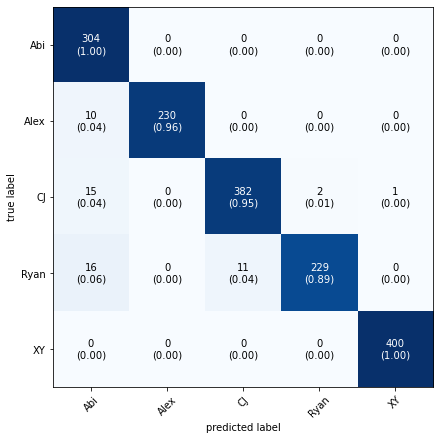

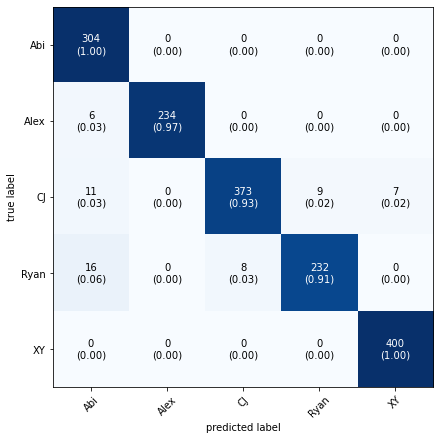

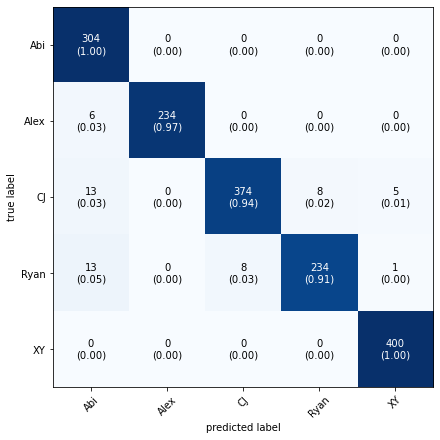

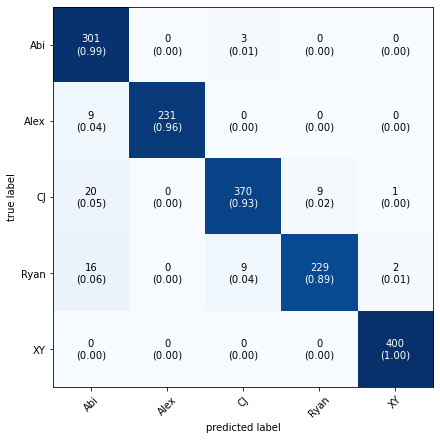

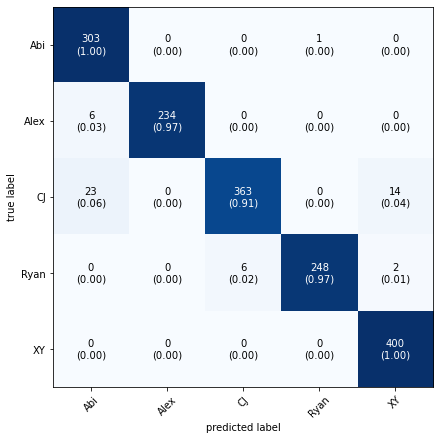

In [417]:
for i in range(5):
    plot_confusion_matrix(conf_mat=cm_hist[i], class_names=encoder_dancer.classes_, show_normed=True, 
                          figsize=(7,7), hide_spines=False)

In [418]:
for i in range(5):
    print("\nClassification Report for fold {}:" .format(i+1))
    print(classification_report_hist[i])


Classification Report for fold 1:
              precision    recall  f1-score   support

         Abi       0.88      1.00      0.94       304
        Alex       1.00      0.96      0.98       240
          CJ       0.97      0.95      0.96       400
        Ryan       0.99      0.89      0.94       256
          XY       1.00      1.00      1.00       400

    accuracy                           0.97      1600
   macro avg       0.97      0.96      0.96      1600
weighted avg       0.97      0.97      0.97      1600


Classification Report for fold 2:
              precision    recall  f1-score   support

         Abi       0.90      1.00      0.95       304
        Alex       1.00      0.97      0.99       240
          CJ       0.98      0.93      0.96       400
        Ryan       0.96      0.91      0.93       256
          XY       0.98      1.00      0.99       400

    accuracy                           0.96      1600
   macro avg       0.97      0.96      0.96      1600
weighte

In [393]:
# good 3 april 1:54am
def perform_mlp(X_test, y_test, fold, pca):
    start_time = timer()
    k = fold
    perform_pca = pca
    number_of_classes = 3
    kf = KFold(n_splits=k, shuffle=True)
    
    #kf = StratifiedKFold(n_splits=k, shuffle=True)

    
# # Trial 3: ave accuracy 81%
#     mlp_adam = nn.MLPClassifier(hidden_layer_sizes=(200, 150), max_iter=500, activation='tanh', solver='adam',
#                                       batch_size = minSamples, validation_fraction=0.2, n_iter_no_change=20,
#                                       alpha=1e-4, early_stopping=True, verbose=0, tol=1e-6, random_state=None, 
#                                       learning_rate_init=0.001, shuffle=False) 

    acc_scores = []
    cv_iteration = 1
    cv_pca_iteration = 1
    train_histories.clear()
    cm_hist.clear()
    classification_report_hist.clear()
#     train_histories_mlp_sgd.clear()
#     train_histories_mlp_adam.clear()
    
    for train_index, val_index in kf.split(X):
        
        if perform_pca == False:
            print('\nTraining model and cross validate using fold #{}...\n ' .format(cv_iteration))
            cv_iteration += 1
        
        X_train , X_val = X.iloc[train_index,:], X.iloc[val_index,:]
        y_train , y_val = y[train_index], y[val_index]
        
        y_val_without_transform = y_val
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        y_train = to_categorical(y_train, number_of_classes)
        y_val = to_categorical(y_val, number_of_classes)
        y_test_categorical = to_categorical(y_test, number_of_classes)
        
        if perform_pca == True:
            print('\nTraining model with PCA and cross validate using fold #{}...\n ' .format(cv_pca_iteration))
            cv_pca_iteration += 1
            pca = PCA(n_components = 12)
            X_train = pca.fit_transform(X_train)
            X_val = pca.transform(X_val)
#             pca.explained_variance_ratio_

        def mlp_model():
            model = Sequential()
#             model.add(Flatten(input_shape=X_train[0].shape))
            model.add(Dense(units=32, kernel_initializer='uniform', activation='relu', input_shape=X_train[0].shape))
#             model.add(Dense(units=64, kernel_initializer='uniform', activation='relu'))
            model.add(Dropout(0.1))
            model.add(Dense(units=16, kernel_initializer='uniform', activation='relu'))
#             model.add(Flatten())
            model.add(Dense(units=number_of_classes, kernel_initializer='uniform', activation='softmax'))
            model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
            return model
        
        mlp = mlp_model()
        print(mlp.summary())        
        
#         checkpoint_filepath="MLP_weights_checkpoint.hdf5"
                
        my_callbacks = [
            EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20),
            ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.00001, patience=20, verbose=1),
#             ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor='val_accuracy',
#                             verbose=1, save_best_only=True, mode='max')  
        ] 
        
        history = mlp.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_val, y_val),
                                  callbacks=[my_callbacks], shuffle=True)
        
        mlp_pred = np.argmax(mlp.predict(X_test_scaled), axis=-1)
        scores = mlp.evaluate(X_test_scaled, y_test_categorical, batch_size=64, verbose=0)
        acc_scores.append(scores[1])
        train_histories.append(history.history)
        
#         mlp_weights = mlp.get_weights()
#         print("MLP Weights:", mlp_weights)
        
#         mlp.save('saved_models/MLP_99.6_accuracy')
        
        print('y_test\n', y_test)
        print('')
        print('mlp_pred\n', mlp_pred)
        
        cm_hist.append(confusion_matrix(y_test, mlp_pred))
        classification_report_hist.append(classification_report(y_test, mlp_pred, target_names=encoder.classes_))
        

    end_time = timer()
    time_taken = end_time - start_time

    return mlp, acc_scores, time_taken

In [377]:
# good 3 april 1:09am
def perform_mlp(X_val, y_val, fold, pca):
    start_time = timer()
    k = fold
    perform_pca = pca
    number_of_classes = 3
    kf = KFold(n_splits=k, shuffle=True)
    
    #kf = StratifiedKFold(n_splits=k, shuffle=True)

    
# # Trial 3: ave accuracy 81%
#     mlp_adam = nn.MLPClassifier(hidden_layer_sizes=(200, 150), max_iter=500, activation='tanh', solver='adam',
#                                       batch_size = minSamples, validation_fraction=0.2, n_iter_no_change=20,
#                                       alpha=1e-4, early_stopping=True, verbose=0, tol=1e-6, random_state=None, 
#                                       learning_rate_init=0.001, shuffle=False) 

    acc_scores = []
    cv_iteration = 1
    cv_pca_iteration = 1
    train_histories.clear()
    cm_hist.clear()
    classification_report_hist.clear()
#     train_histories_mlp_sgd.clear()
#     train_histories_mlp_adam.clear()
    
    for train_index, test_index in kf.split(X):
        
        if perform_pca == False:
            print('\nTraining model and cross validate using fold #{}...\n ' .format(cv_iteration))
            cv_iteration += 1
        
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train , y_test = y[train_index], y[test_index]
        
#         print('X_train', X_train)
#         print('X_test', X_test)

#         print('X_train and X_test shape before standard scaler:')
#         print('X_train shape:', X_train.shape)
#         print('X_test shape:', X_test.shape)

        y_test_without_transform = y_test

#         print('X_train before standard scaler: ', X_train)
#         print('X_test before standard scaler: ', X_test)        
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        X_val_std_scaler = scaler.transform(X_val)
        
#         print('X_train and X_test shape after standard scaler:')
#         print('X_train shape:', X_train.shape)
#         print('X_test shape:', X_test.shape)
        
#         scaler = StandardScaler()
#         X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
#         X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
#         print('X_train shape:', X_train.shape)
#         print('X_test shape:', X_test.shape)        

        
        y_train = to_categorical(y_train, number_of_classes)
        y_test = to_categorical(y_test, number_of_classes)
        y_val_categorical = to_categorical(y_val, number_of_classes)
        
#         X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
#         X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)     
        
#         print('X_train shape:', X_train.shape)
#         print('X_test shape:', X_test.shape)
        
        if perform_pca == True:
            print('\nTraining model with PCA and cross validate using fold #{}...\n ' .format(cv_pca_iteration))
            cv_pca_iteration += 1
            pca = PCA(n_components = 4) # n=100 is the usual consensus in HAR
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
            pca.explained_variance_ratio_

        def mlp_model():
            model = Sequential()
#             model.add(Flatten(input_shape=X_train[0].shape))
            model.add(Dense(units=32, kernel_initializer='uniform', activation='relu', input_shape=X_train[0].shape))
#             model.add(Dense(units=64, kernel_initializer='uniform', activation='relu'))
            model.add(Dropout(0.1))
            model.add(Dense(units=16, kernel_initializer='uniform', activation='relu'))
#             model.add(Flatten())
            model.add(Dense(units=number_of_classes, kernel_initializer='uniform', activation='softmax'))
            model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
            return model
        
        mlp = mlp_model()
        print(mlp.summary())        
        
#         checkpoint_filepath="MLP_weights_checkpoint.hdf5"
                
        my_callbacks = [
            EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20),
            ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.00001, patience=20, verbose=1),
#             ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor='val_accuracy',
#                             verbose=1, save_best_only=True, mode='max')  
        ] 
        
        history = mlp.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_test, y_test),
                                  callbacks=[my_callbacks], shuffle=True)
        
        mlp_pred = np.argmax(mlp.predict(X_val_std_scaler), axis=-1)
        scores = mlp.evaluate(X_val_std_scaler, y_val_categorical, batch_size=64, verbose=0)
        acc_scores.append(scores[1])
        train_histories.append(history.history)
        
#         mlp_weights = mlp.get_weights()
#         print("MLP Weights:", mlp_weights)
        
#         mlp.save('saved_models/MLP_99.6_accuracy')
        
        print('y_test\n', y_val)
        print('')
        print('mlp_pred\n', mlp_pred)
        
        cm_hist.append(confusion_matrix(y_val, mlp_pred))
        classification_report_hist.append(classification_report(y_val, mlp_pred, target_names=encoder.classes_))
        

    end_time = timer()
    time_taken = end_time - start_time

    return mlp, acc_scores, time_taken

In [394]:
mlp_model, acc_scores, time_taken = perform_mlp(X_test, y_test, fold=5, pca=False)


Training model with PCA and cross validate using fold #1...
 
Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_318 (Dense)            (None, 32)                416       
_________________________________________________________________
dropout_123 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_319 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_320 (Dense)            (None, 3)                 51        
Total params: 995
Trainable params: 995
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
49/49 [==============================] - 1s 4ms/step - loss: 1.0894 - accuracy: 0.5723 - val_loss: 0.9847 - val_accuracy: 0.7008
Epoch 2/200
49/49 [========================

49/49 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 52/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9984 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 53/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0048 - accuracy: 0.9985 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 54/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 55/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 56/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 0.9999 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 57/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 0.9998 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 58/200
49/49 

49/49 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 0.9996 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 108/200
49/49 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 0.9998 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 109/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 110/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 111/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 0.9998 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 112/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 113/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 0.9998 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 114/200

49/49 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000

Epoch 00163: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
Epoch 164/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9999 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 00164: early stopping
y_test
 [0 0 0 ... 2 2 2]

mlp_pred
 [1 1 1 ... 1 1 1]

Training model with PCA and cross validate using fold #2...
 
Model: "sequential_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_321 (Dense)            (None, 32)                416       
_________________________________________________________________
dropout_124 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_322 (Dense)            (None, 16)                528       
_______________

/Users/yeapcl/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 1s 5ms/step - loss: 1.0914 - accuracy: 0.6667 - val_loss: 0.9890 - val_accuracy: 0.9144
Epoch 2/200
49/49 [==============================] - 0s 2ms/step - loss: 0.8846 - accuracy: 0.8973 - val_loss: 0.4512 - val_accuracy: 0.9702
Epoch 3/200
49/49 [==============================] - 0s 2ms/step - loss: 0.3636 - accuracy: 0.9699 - val_loss: 0.1361 - val_accuracy: 0.9844
Epoch 4/200
49/49 [==============================] - 0s 2ms/step - loss: 0.1213 - accuracy: 0.9820 - val_loss: 0.0749 - val_accuracy: 0.9857
Epoch 5/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.9863 - val_loss: 0.0591 - val_accuracy: 0.9857
Epoch 6/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0504 - accuracy: 0.9910 - val_loss: 0.0505 - val_accuracy: 0.9857
Epoch 7/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0441 - accuracy: 0.9893 - val_loss: 0.0431 - val_accuracy: 0.9857
Epoch 8/200
49/49 [======

49/49 [==============================] - 0s 2ms/step - loss: 0.0067 - accuracy: 0.9982 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 59/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 60/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.9989 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 61/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 62/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 63/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 64/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 65/200
49/49 

/Users/yeapcl/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 1s 5ms/step - loss: 1.0908 - accuracy: 0.5016 - val_loss: 0.9987 - val_accuracy: 0.9676
Epoch 2/200
49/49 [==============================] - 0s 1ms/step - loss: 0.8759 - accuracy: 0.9720 - val_loss: 0.3970 - val_accuracy: 0.9676
Epoch 3/200
49/49 [==============================] - 0s 2ms/step - loss: 0.2820 - accuracy: 0.9762 - val_loss: 0.1179 - val_accuracy: 0.9805
Epoch 4/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0973 - accuracy: 0.9831 - val_loss: 0.0751 - val_accuracy: 0.9857
Epoch 5/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0626 - accuracy: 0.9893 - val_loss: 0.0601 - val_accuracy: 0.9870
Epoch 6/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0489 - accuracy: 0.9911 - val_loss: 0.0530 - val_accuracy: 0.9883
Epoch 7/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0432 - accuracy: 0.9900 - val_loss: 0.0461 - val_accuracy: 0.9870
Epoch 8/200
49/49 [======

Epoch 58/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 8.8423e-04 - val_accuracy: 1.0000

Epoch 00058: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 59/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 0.9997 - val_loss: 8.8155e-04 - val_accuracy: 1.0000
Epoch 60/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 8.7986e-04 - val_accuracy: 1.0000
Epoch 61/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 8.7936e-04 - val_accuracy: 1.0000
Epoch 62/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 8.7772e-04 - val_accuracy: 1.0000
Epoch 63/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 8.7662e-04 - val_accuracy: 1.0000
Epoch 64/200
49/49 [======================

49/49 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 8.5878e-04 - val_accuracy: 1.0000
Epoch 113/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 8.5877e-04 - val_accuracy: 1.0000
Epoch 114/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 8.5878e-04 - val_accuracy: 1.0000
Epoch 115/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9979 - val_loss: 8.5881e-04 - val_accuracy: 1.0000
Epoch 116/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 8.5879e-04 - val_accuracy: 1.0000
Epoch 117/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 8.5877e-04 - val_accuracy: 1.0000
Epoch 118/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9999 - val_loss: 8.5876e-04 - val_ac

/Users/yeapcl/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 1s 4ms/step - loss: 1.0899 - accuracy: 0.4866 - val_loss: 0.9951 - val_accuracy: 0.9287
Epoch 2/200
49/49 [==============================] - 0s 2ms/step - loss: 0.8798 - accuracy: 0.9472 - val_loss: 0.4188 - val_accuracy: 0.9728
Epoch 3/200
49/49 [==============================] - 0s 2ms/step - loss: 0.3176 - accuracy: 0.9669 - val_loss: 0.1129 - val_accuracy: 0.9883
Epoch 4/200
49/49 [==============================] - 0s 2ms/step - loss: 0.1067 - accuracy: 0.9820 - val_loss: 0.0593 - val_accuracy: 0.9935
Epoch 5/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0764 - accuracy: 0.9840 - val_loss: 0.0415 - val_accuracy: 0.9948
Epoch 6/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0540 - accuracy: 0.9904 - val_loss: 0.0327 - val_accuracy: 0.9948
Epoch 7/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0483 - accuracy: 0.9863 - val_loss: 0.0255 - val_accuracy: 0.9948
Epoch 8/200
49/49 [======

49/49 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 0.9999 - val_loss: 8.9736e-04 - val_accuracy: 1.0000
Epoch 58/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 0.9984 - val_loss: 8.9649e-04 - val_accuracy: 1.0000
Epoch 59/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 0.9997 - val_loss: 8.9556e-04 - val_accuracy: 1.0000
Epoch 60/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 8.8846e-04 - val_accuracy: 1.0000
Epoch 61/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 8.8341e-04 - val_accuracy: 1.0000
Epoch 62/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 8.8273e-04 - val_accuracy: 1.0000
Epoch 63/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 8.8046e-04 - val_accuracy

/Users/yeapcl/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 0s 4ms/step - loss: 1.0889 - accuracy: 0.3997 - val_loss: 0.9739 - val_accuracy: 0.4656
Epoch 2/200
49/49 [==============================] - 0s 2ms/step - loss: 0.8694 - accuracy: 0.7467 - val_loss: 0.4966 - val_accuracy: 0.9442
Epoch 3/200
49/49 [==============================] - 0s 2ms/step - loss: 0.4021 - accuracy: 0.9593 - val_loss: 0.1478 - val_accuracy: 0.9831
Epoch 4/200
49/49 [==============================] - 0s 2ms/step - loss: 0.1232 - accuracy: 0.9818 - val_loss: 0.0767 - val_accuracy: 0.9896
Epoch 5/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0689 - accuracy: 0.9908 - val_loss: 0.0604 - val_accuracy: 0.9896
Epoch 6/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0525 - accuracy: 0.9900 - val_loss: 0.0494 - val_accuracy: 0.9870
Epoch 7/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0381 - accuracy: 0.9917 - val_loss: 0.0435 - val_accuracy: 0.9870
Epoch 8/200
49/49 [======

49/49 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 59/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 60/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 61/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 62/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 63/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 64/200
49/49 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 65/200
49/49 

/Users/yeapcl/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [412]:
print('MLP - prediction accuracy of each fold:\n {}'.format(acc_scores))
print('')
print('MLP - average accuracy in 5-fold = {} with std. deviation {}' .format(np.mean(acc_scores), np.std(acc_scores)))
print('')
print('Time taken: {:.2f} seconds' .format(time_taken))

MLP - prediction accuracy of each fold:
 [0.30000001192092896, 0.30000001192092896, 0.30000001192092896, 0.30000001192092896, 0.30000001192092896]

MLP - average accuracy in 5-fold = 0.30000001192092896 with std. deviation 0.0

Time taken: 51.27 seconds


In [416]:
for i in range(5):
    plot_confusion_matrix(conf_mat=cm_hist[i], class_names=encoder.classes_, show_normed=True, 
                          figsize=(7,7), hide_spines=False)

AssertionError: len(class_names) should be equal to number ofclasses in the dataset

In [373]:
for i in range(5):
    print("\nClassification Report for fold {}:" .format(i+1))
    print(classification_report_hist[i])


Classification Report for fold 1:
              precision    recall  f1-score   support

         gun       0.96      0.98      0.97       432
        hair       0.98      1.00      0.99       480
    sidepump       1.00      0.98      0.99       688

    accuracy                           0.98      1600
   macro avg       0.98      0.99      0.98      1600
weighted avg       0.98      0.98      0.98      1600


Classification Report for fold 2:
              precision    recall  f1-score   support

         gun       0.96      0.98      0.97       432
        hair       0.98      1.00      0.99       480
    sidepump       1.00      0.98      0.99       688

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600


Classification Report for fold 3:
              precision    recall  f1-score   support

         gun       0.96      0.98      0.97       432
        hair       0.98 

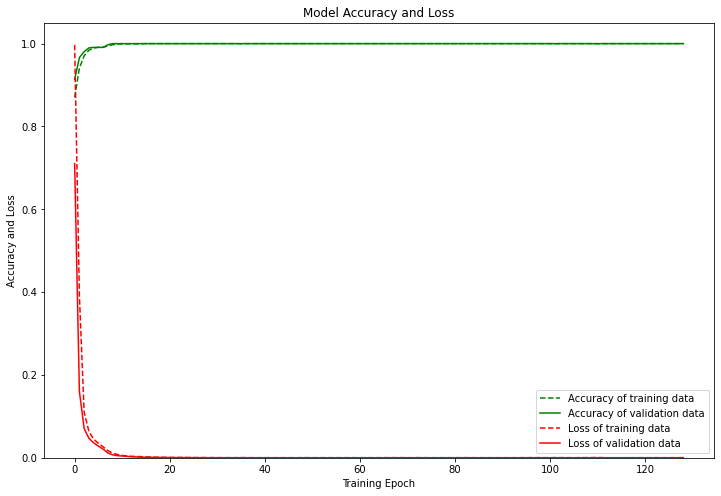

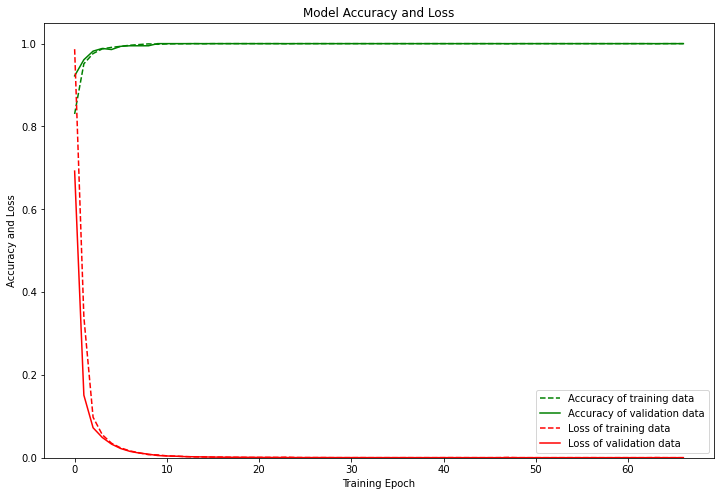

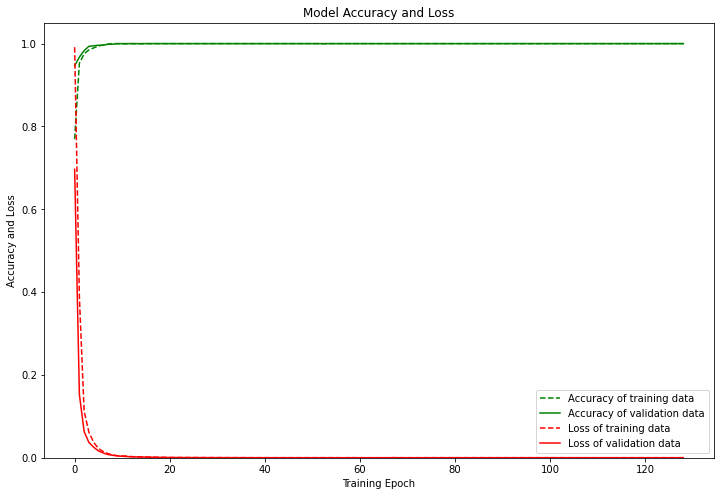

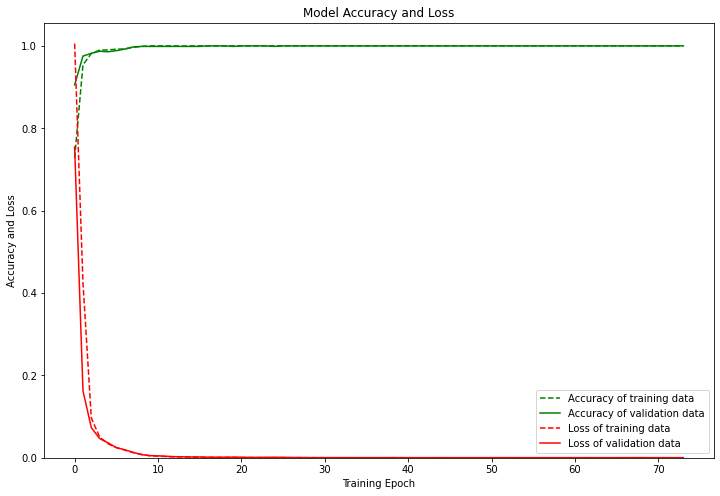

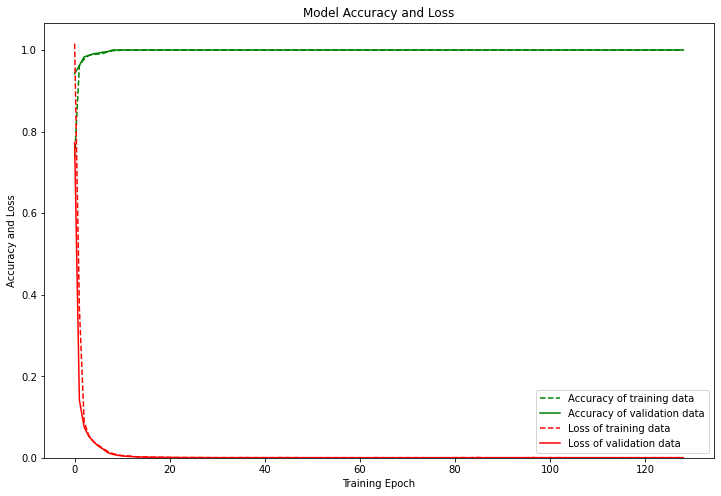

In [362]:
for history in train_histories:
    plt.figure(figsize=(12, 8))
    plt.plot(history['accuracy'], "g--", label="Accuracy of training data")
    plt.plot(history['val_accuracy'], "g", label="Accuracy of validation data")
    plt.plot(history['loss'], "r--", label="Loss of training data")
    plt.plot(history['val_loss'], "r", label="Loss of validation data")
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

In [ ]:
X_val

In [73]:
scaler2 = StandardScaler()
# X_train = scaler2.fit_transform(X_train)
X_val2 = scaler2.fit_transform(X_val)
hhdds = pd.DataFrame(X_val2)
hhdds

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,-1.088730,-0.127596,-1.385538,-0.892889,0.194735,-1.746761,1.421869,-0.235242,1.229765,1.241227,-0.456665,0.323502,0.954254,1.084440,0.343333,0.105532,0.202017,-0.993289,-0.429881,-1.105154,0.279719,0.688370,0.176828,0.445442,-1.543907,1.005676
1,-1.069072,-0.127857,-1.381500,-0.891119,0.194600,-1.752683,1.419024,-0.256786,1.230025,1.256185,-0.486099,0.323691,0.949866,1.080554,0.289763,0.160513,0.201982,-0.996781,-0.430804,-1.087847,0.279674,0.702085,0.179340,0.447299,-1.531123,0.991554
2,-1.049455,-0.117360,-1.377789,-0.889368,0.197791,-1.758113,1.413791,-0.277053,1.222976,1.269993,-0.515316,0.315999,0.945764,1.051407,0.211843,0.154404,0.201628,-1.003071,-0.430832,-1.051580,0.279797,0.735881,0.179590,0.461162,-1.523140,0.993164
3,-1.026340,-0.108389,-1.375465,-0.887544,0.200528,-1.761438,1.411215,-0.294904,1.216957,1.278377,-0.551185,0.309433,0.942908,1.004772,0.143664,0.123859,0.200865,-1.008354,-0.430931,-1.014338,0.281028,0.763925,0.180692,0.483217,-1.513884,1.001204
4,-1.000713,-0.108898,-1.374981,-0.885748,0.200356,-1.762112,1.413854,-0.308670,1.217324,1.280049,-0.592113,0.309804,0.942246,0.965909,0.099834,0.081096,0.200321,-1.011405,-0.431585,-0.984460,0.281763,0.778641,0.184395,0.501677,-1.504520,1.012496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.471750,1.741507,0.841135,1.524948,-1.316009,0.262825,-1.472785,-0.954595,-0.794735,0.063399,-1.176676,-1.374970,-1.118399,-1.688394,-0.830329,-0.254896,-1.285691,1.526608,1.086842,1.789111,1.567759,0.794153,1.602927,-2.130023,-0.051556,-1.913764
236,0.810128,2.243463,0.575408,1.524948,-1.316009,0.262825,-1.259638,-0.954595,-0.794735,0.063399,-1.176676,-1.374970,-1.118399,-1.688394,-0.830329,-0.254896,-1.285691,1.526608,1.086842,1.789111,1.567759,0.794153,1.602927,-2.130023,-0.051556,-1.913764
237,1.397171,2.578076,0.296587,1.524948,-1.316009,0.262825,-0.894243,-0.954595,-0.794735,0.063399,-1.176676,-1.374970,-1.118399,-1.688394,-0.830329,-0.254896,-1.285691,1.526608,1.086842,1.789111,1.567759,0.794153,1.602927,-2.130023,-0.051556,-1.913764
238,1.615547,2.954857,0.107144,1.524948,-1.316009,0.262825,-0.707935,-0.954595,-0.794735,0.063399,-1.176676,-1.374970,-1.118399,-1.688394,-0.830329,-0.254896,-1.285691,1.526608,1.086842,1.789111,1.567759,0.794153,1.602927,-2.130023,-0.051556,-1.913764


In [87]:
y_val2 = to_categorical(y_val, 3)
ds22 = mlp_model.evaluate(X_val, y_val2, batch_size=32, verbose=0)

In [88]:
ds22

[0.000791842641774565, 1.0]

In [89]:
mlp_pred2 = np.argmax(mlp_model.predict(X_val), axis=-1)

In [64]:
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [90]:
mlp_pred2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [102]:
features_train.to_csv('dataset/extracted_features/features_train.csv', index=False)

In [63]:
pd.set_option("display.max_rows", 100, "display.max_columns", 100)
np.set_printoptions(threshold=1000) # 'sys.maxsize' for max

In [17]:
xyz_acc_mean_train = pd.DataFrame(get_mean(xyz_acc_train), columns=['acc_X_mean', 'acc_Y_mean', 'acc_Z_mean'])
xyz_acc_std_train = pd.DataFrame(get_std(xyz_acc_train), columns=['acc_X_std', 'acc_Y_std', 'acc_Z_std'])
xyz_acc_mag_train = pd.DataFrame(get_mag(xyz_acc_mean_train), columns=['acc_mag'])
xyz_acc_kurtosis_train = pd.DataFrame(get_kurtosis(xyz_acc_train), columns=['acc_X_kurtosis', 'acc_Y_kurtosis', 'acc_Z_kurtosis'])
xyz_acc_skew_train = pd.DataFrame(get_skew(xyz_acc_train), columns=['acc_X_skew', 'acc_Y_skew', 'acc_Z_skew'])
# xyz_acc_ft = pd.DataFrame(fourier_transform(xyz_acc_mean), columns=['acc_X_fourier', 'acc_Y_fourier', 'acc_Z_fourier'])

In [18]:
xyz_acc_mean_test = pd.DataFrame(get_mean(xyz_acc_test), columns=['acc_X_mean', 'acc_Y_mean', 'acc_Z_mean'])
xyz_acc_std_test = pd.DataFrame(get_std(xyz_acc_test), columns=['acc_X_std', 'acc_Y_std', 'acc_Z_std'])
xyz_acc_mag_test = pd.DataFrame(get_mag(xyz_acc_mean_test), columns=['acc_mag'])
xyz_acc_kurtosis_test = pd.DataFrame(get_kurtosis(xyz_acc_test), columns=['acc_X_kurtosis', 'acc_Y_kurtosis', 'acc_Z_kurtosis'])
xyz_acc_skew_test = pd.DataFrame(get_skew(xyz_acc_test), columns=['acc_X_skew', 'acc_Y_skew', 'acc_Z_skew'])
# xyz_acc_ft = pd.DataFrame(fourier_transform(xyz_acc_mean), columns=['acc_X_fourier', 'acc_Y_fourier', 'acc_Z_fourier'])

In [19]:
xyz_gyro_mean_train = pd.DataFrame(get_mean(xyz_gyro_train), columns=['gyro_X_mean', 'gyro_Y_mean', 'gyro_Z_mean'])
xyz_gyro_std_train = pd.DataFrame(get_std(xyz_gyro_train), columns=['gyro_X_std', 'gyro_Y_std', 'gyro_Z_std'])
xyz_gyro_mag_train = pd.DataFrame(get_mag(xyz_gyro_mean_train), columns=['gyro_mag'])
xyz_gyro_kurtosis_train = pd.DataFrame(get_kurtosis(xyz_gyro_train), columns=['gyro_X_kurtosis', 'gyro_Y_kurtosis', 'gyro_Z_kurtosis'])
xyz_gyro_skew_train = pd.DataFrame(get_skew(xyz_gyro_train), columns=['gyro_X_skew', 'gyro_Y_skew', 'gyro_Z_skew'])
# xyz_gyro_ft = pd.DataFrame(fourier_transform(xyz_gyro), columns=['gyro_X_fourier', 'gyro_Y_fourier', 'gyro_Z_fourier'])

In [20]:
xyz_gyro_mean_test = pd.DataFrame(get_mean(xyz_gyro_test), columns=['gyro_X_mean', 'gyro_Y_mean', 'gyro_Z_mean'])
xyz_gyro_std_test = pd.DataFrame(get_std(xyz_gyro_test), columns=['gyro_X_std', 'gyro_Y_std', 'gyro_Z_std'])
xyz_gyro_mag_test = pd.DataFrame(get_mag(xyz_gyro_mean_test), columns=['gyro_mag'])
xyz_gyro_kurtosis_test = pd.DataFrame(get_kurtosis(xyz_gyro_test), columns=['gyro_X_kurtosis', 'gyro_Y_kurtosis', 'gyro_Z_kurtosis'])
xyz_gyro_skew_test = pd.DataFrame(get_skew(xyz_gyro_test), columns=['gyro_X_skew', 'gyro_Y_skew', 'gyro_Z_skew'])
# xyz_gyro_ft = pd.DataFrame(fourier_transform(xyz_gyro), columns=['gyro_X_fourier', 'gyro_Y_fourier', 'gyro_Z_fourier'])

In [21]:
# data883 = []
# data_temp883 = []
# for col in range(xyz_acc.shape[1]):
#     for row in range(xyz_acc.shape[0]):
#         print('count: ', row)
# #         print(xyz_acc.iloc[row, col])
#         dsd2 = np.std(xyz_acc.iloc[row, col])
#         print(dsd2)
#         data_temp883.append(dsd2)
# data_temp883 = []

In [22]:
# for col in range(xyz_acc_mean.shape[1]):
#     for row in range(xyz_acc_mean.shape[0]):
#         print(xyz_acc_mean.values[row][col])
    

In [ ]:
# features_df = pd.concat([xyz_acc_mean, xyz_acc_std], axis=1)
features_train = pd.concat([xyz_acc_mean_train, xyz_acc_std_train, xyz_acc_mag_train,
                         xyz_acc_kurtosis_train, xyz_acc_skew_train,
                         xyz_gyro_mean_train, xyz_gyro_std_train, xyz_gyro_mag_train,
                         xyz_gyro_kurtosis_train, xyz_gyro_skew_train], axis=1)
features_train

In [ ]:
# features_df = pd.concat([xyz_acc_mean, xyz_acc_std], axis=1)
features_test = pd.concat([xyz_acc_mean_test, xyz_acc_std_test, xyz_acc_mag_test,
                         xyz_acc_kurtosis_test, xyz_acc_skew_test,
                         xyz_gyro_mean_test, xyz_gyro_std_test, xyz_gyro_mag_test,
                         xyz_gyro_kurtosis_test, xyz_gyro_skew_test], axis=1)
features_test

In [ ]:
features_train['Dancer'] = 'Alex'
features_train['Move'] = train_danceMove_Alex.movename
features_train

In [ ]:
features_test['Dancer'] = 'Alex'
features_test['Move'] = test_danceMove_Alex.movename
features_test

In [ ]:
X = features_train.iloc[:, :-2]
X

In [28]:
X_val = features_test.iloc[:, :-2]
X_val

,acc_X_mean,acc_Y_mean,acc_Z_mean,acc_X_std,acc_Y_std,acc_Z_std,acc_mag,acc_X_kurtosis,acc_Y_kurtosis,acc_Z_kurtosis,acc_X_skew,acc_Y_skew,acc_Z_skew,gyro_X_mean,gyro_Y_mean,gyro_Z_mean,gyro_X_std,gyro_Y_std,gyro_Z_std,gyro_mag,gyro_X_kurtosis,gyro_Y_kurtosis,gyro_Z_kurtosis,gyro_X_skew,gyro_Y_skew,gyro_Z_skew
0,0.256790,-0.462554,-0.784829,0.130087,0.591135,0.371541,0.946495,-0.224492,2.002373,-0.555826,-0.382008,0.578464,0.735185,0.429688,-5.937500,-2.285156,136.164216,27.500832,49.382057,6.376557,-0.071116,3.116190,2.278384,-0.150386,-1.422626,0.155111
1,0.257769,-0.462569,-0.784113,0.130428,0.591126,0.371121,0.946176,-0.240044,2.002696,-0.551996,-0.398504,0.578550,0.733888,0.390625,-6.152344,-2.109375,136.162653,27.423676,49.367088,6.515626,-0.071154,3.138564,2.282634,-0.149532,-1.414567,0.144675
2,0.258747,-0.461937,-0.783456,0.130765,0.591316,0.370737,0.945589,-0.254675,1.993933,-0.548460,-0.414879,0.575078,0.732676,0.097656,-6.464844,-2.128906,136.146788,27.284667,49.366636,6.807054,-0.071051,3.193697,2.283057,-0.143155,-1.409535,0.145865
3,0.259899,-0.461397,-0.783044,0.131116,0.591479,0.370501,0.945301,-0.267562,1.986450,-0.546314,-0.434982,0.572115,0.731832,-0.371094,-6.738281,-2.226562,136.112690,27.167927,49.365032,7.106316,-0.070031,3.239446,2.284921,-0.133009,-1.403701,0.151807
4,0.261176,-0.461428,-0.782958,0.131461,0.591469,0.370453,0.945596,-0.277500,1.986906,-0.545886,-0.457919,0.572282,0.731636,-0.761719,-6.914062,-2.363281,136.088361,27.100509,49.354425,7.346399,-0.069421,3.263453,2.291185,-0.124516,-1.397798,0.160152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.334560,-0.350046,-0.390334,0.595231,0.501368,0.513918,0.621951,-0.743796,-0.514374,-0.857406,-0.785536,-0.188064,0.122606,-27.441406,-10.644531,-3.437500,69.624660,83.184039,73.982519,29.633650,0.997362,3.288758,4.690904,-1.335196,-0.481920,-2.002434
236,0.351424,-0.319832,-0.437412,0.595231,0.501368,0.513918,0.645849,-0.743796,-0.514374,-0.857406,-0.785536,-0.188064,0.122606,-27.441406,-10.644531,-3.437500,69.624660,83.184039,73.982519,29.633650,0.997362,3.288758,4.690904,-1.335196,-0.481920,-2.002434
237,0.380681,-0.299691,-0.486810,0.595231,0.501368,0.513918,0.686817,-0.743796,-0.514374,-0.857406,-0.785536,-0.188064,0.122606,-27.441406,-10.644531,-3.437500,69.624660,83.184039,73.982519,29.633650,0.997362,3.288758,4.690904,-1.335196,-0.481920,-2.002434
238,0.391565,-0.277011,-0.520373,0.595231,0.501368,0.513918,0.707705,-0.743796,-0.514374,-0.857406,-0.785536,-0.188064,0.122606,-27.441406,-10.644531,-3.437500,69.624660,83.184039,73.982519,29.633650,0.997362,3.288758,4.690904,-1.335196,-0.481920,-2.002434


In [ ]:
dsd2 = features_df.iloc[0:, 0:3]
dsd2

In [ ]:
dsd2.values[0][0]

In [ ]:
sdh2 = train_danceMove_Alex.a_xList[0]
sdh2

In [ ]:
mag33 = []
# for row in range(dsd2.shape[0]):
for i in range(dsd2.shape[0]):
    x, y, z = dsd2.values[i]
#     print(x, y, z)
    mag33.append(sqrt(pow(x, 2) + pow(y, 2) + pow(z, 2)))
mag33

In [ ]:
kurtosis(sdh2)

In [ ]:
skew(train_danceMove_Alex.a_xList[9])

In [ ]:
kurtosis([1])

In [ ]:
skew([1,1,3])

In [ ]:
data22 = []
data_temp22 = []
for col in range(x.shape[1]):
    for row in range(x.shape[0]):
        data_temp.append(np.fft.fft(x.iloc[row, col]))
        if row == x.shape[0]-1:
            data.append(data_temp)


In [ ]:
features_df['Dancer'] = 'Alex'
features_df['Move'] = train_danceMove_Alex.movename

In [ ]:
features_df

In [ ]:
np.mean(train_danceMove_Alex.g_zList[2])

In [ ]:
features_df.insert(, 'Dancer', 'Alex')
features_df

In [ ]:
features_df.insert(4, 'Move', train_danceMove_Alex.movename)

In [ ]:
features_df = features_df.drop('Dancer', 1)
features_df

In [ ]:
features_df

In [ ]:
# backup - working and good!
def perform_mlp(X_val, y_val, fold, pca):
    start_time = timer()
    k = fold
    perform_pca = pca
    number_of_classes = 3
    kf = KFold(n_splits=k, shuffle=True)
    
    #kf = StratifiedKFold(n_splits=k, shuffle=True)

    
# # Trial 3: ave accuracy 81%
#     mlp_adam = nn.MLPClassifier(hidden_layer_sizes=(200, 150), max_iter=500, activation='tanh', solver='adam',
#                                       batch_size = minSamples, validation_fraction=0.2, n_iter_no_change=20,
#                                       alpha=1e-4, early_stopping=True, verbose=0, tol=1e-6, random_state=None, 
#                                       learning_rate_init=0.001, shuffle=False) 

    acc_scores = []
    cv_iteration = 1
    cv_pca_iteration = 1
    train_histories.clear()
    cm_hist.clear()
    classification_report_hist.clear()
#     train_histories_mlp_sgd.clear()
#     train_histories_mlp_adam.clear()
    
    for train_index, test_index in kf.split(X):
        
        if perform_pca == False:
            print('\nTraining model and cross validate using fold #{}...\n ' .format(cv_iteration))
            cv_iteration += 1
        
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train , y_test = y[train_index], y[test_index]
        
#         print('X_train', X_train)
#         print('X_test', X_test)

#         print('X_train and X_test shape before standard scaler:')
#         print('X_train shape:', X_train.shape)
#         print('X_test shape:', X_test.shape)

        y_test_without_transform = y_test

#         print('X_train before standard scaler: ', X_train)
#         print('X_test before standard scaler: ', X_test)        
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        X_val_std_scaler = scaler.transform(X_val)
        
#         print('X_train and X_test shape after standard scaler:')
#         print('X_train shape:', X_train.shape)
#         print('X_test shape:', X_test.shape)
        
#         scaler = StandardScaler()
#         X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
#         X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
#         print('X_train shape:', X_train.shape)
#         print('X_test shape:', X_test.shape)        

        
        y_train = to_categorical(y_train, number_of_classes)
        y_test = to_categorical(y_test, number_of_classes)
        y_val_categorical = to_categorical(y_val, number_of_classes)
        
#         X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
#         X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)     
        
#         print('X_train shape:', X_train.shape)
#         print('X_test shape:', X_test.shape)
        
        if perform_pca == True:
            print('\nTraining model with PCA and cross validate using fold #{}...\n ' .format(cv_pca_iteration))
            cv_pca_iteration += 1
            pca = PCA(n_components = 4) # n=100 is the usual consensus in HAR
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
            pca.explained_variance_ratio_

        def mlp_model():
            model = Sequential()
#             model.add(Flatten(input_shape=X_train[0].shape))
            model.add(Dense(units=64, kernel_initializer='uniform', activation='relu', input_shape=X_train[0].shape))
#             model.add(Dense(units=64, kernel_initializer='uniform', activation='relu'))
            model.add(Dropout(0.1))
            model.add(Dense(units=16, kernel_initializer='uniform', activation='relu'))
#             model.add(Flatten())
            model.add(Dense(units=number_of_classes, kernel_initializer='uniform', activation='softmax'))
            model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
            return model
        
        mlp = mlp_model()
        print(mlp.summary())        
        
#         checkpoint_filepath="MLP_weights_checkpoint.hdf5"
                
        my_callbacks = [
            EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20),
            ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.00001, patience=20, verbose=1),
#             ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor='val_accuracy',
#                             verbose=1, save_best_only=True, mode='max')  
        ] 
        
        history = mlp.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_test, y_test),
                                  callbacks=[my_callbacks])
        
        mlp_pred = np.argmax(mlp.predict(X_test), axis=-1)
        scores = mlp.evaluate(X_test, y_test, batch_size=64, verbose=0)
        acc_scores.append(scores[1])
        train_histories.append(history.history)
        
        mlp_weights = mlp.get_weights()
        print("MLP Weights:", mlp_weights)
        
#         mlp.save('saved_models/MLP_99.6_accuracy')
        
        print('y_test\n', y_test_without_transform)
        print('')
        print('mlp_pred\n', mlp_pred)
        
        cm_hist.append(confusion_matrix(y_test_without_transform, mlp_pred))
        classification_report_hist.append(classification_report(y_test_without_transform, mlp_pred, target_names=encoder.classes_))
        

    end_time = timer()
    time_taken = end_time - start_time

    return mlp, acc_scores, time_taken

In [355]:
# 75% accuracy -- bug exists somewhere
def perform_mlp(X_test, y_test, fold, pca):
    start_time = timer()
    k = fold
    perform_pca = pca
    number_of_classes = 3
    kf = KFold(n_splits=k, shuffle=True)
    
    #kf = StratifiedKFold(n_splits=k, shuffle=True)

    
# # Trial 3: ave accuracy 81%
#     mlp_adam = nn.MLPClassifier(hidden_layer_sizes=(200, 150), max_iter=500, activation='tanh', solver='adam',
#                                       batch_size = minSamples, validation_fraction=0.2, n_iter_no_change=20,
#                                       alpha=1e-4, early_stopping=True, verbose=0, tol=1e-6, random_state=None, 
#                                       learning_rate_init=0.001, shuffle=False) 

    acc_scores = []
    cv_iteration = 1
    cv_pca_iteration = 1
    train_histories.clear()
    cm_hist.clear()
    classification_report_hist.clear()
#     train_histories_mlp_sgd.clear()
#     train_histories_mlp_adam.clear()
    
    for train_index, val_index in kf.split(X):
        
        if perform_pca == False:
            print('\nTraining model and cross validate using fold #{}...\n ' .format(cv_iteration))
            cv_iteration += 1
        
        X_train , X_val = X.iloc[train_index,:], X.iloc[val_index,:]
        y_train , y_val = y[train_index], y[val_index]
        
#         print('X_train', X_train)
#         print('X_test', X_test)

#         print('X_train and X_test shape before standard scaler:')
#         print('X_train shape:', X_train.shape)
#         print('X_test shape:', X_test.shape)

        y_val_without_transform = y_val

#         print('X_train before standard scaler: ', X_train)
#         print('X_test before standard scaler: ', X_test)        
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test_std_scaler = scaler.transform(X_test)
        
#         print('X_train and X_test shape after standard scaler:')
#         print('X_train shape:', X_train.shape)
#         print('X_test shape:', X_test.shape)
        
#         scaler = StandardScaler()
#         X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
#         X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
#         print('X_train shape:', X_train.shape)
#         print('X_test shape:', X_test.shape)        

        
        y_train = to_categorical(y_train, number_of_classes)
        y_val = to_categorical(y_val, number_of_classes)
        y_test_categorical = to_categorical(y_test, number_of_classes)
        
#         X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
#         X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)     
        
#         print('X_train shape:', X_train.shape)
#         print('X_test shape:', X_test.shape)
        
        if perform_pca == True:
            print('\nTraining model with PCA and cross validate using fold #{}...\n ' .format(cv_pca_iteration))
            cv_pca_iteration += 1
            pca = PCA(n_components = 4) # n=100 is the usual consensus in HAR
            X_train = pca.fit_transform(X_train)
            X_val = pca.transform(X_val)
            pca.explained_variance_ratio_

        def mlp_model():
            model = Sequential()
#             model.add(Flatten(input_shape=X_train[0].shape))
            model.add(Dense(units=32, kernel_initializer='uniform', activation='relu', input_shape=X_train[0].shape))
#             model.add(Dense(units=64, kernel_initializer='uniform', activation='relu'))
            model.add(Dropout(0.1))
#             model.add(Dense(units=16, kernel_initializer='uniform', activation='relu'))
#             model.add(Flatten())
            model.add(Dense(units=number_of_classes, kernel_initializer='uniform', activation='softmax'))
            model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
            return model
        
        mlp = mlp_model()
        print(mlp.summary())        
        
#         checkpoint_filepath="MLP_weights_checkpoint.hdf5"
                
        my_callbacks = [
            EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20),
            ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.00001, patience=20, verbose=1),
#             ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor='val_accuracy',
#                             verbose=1, save_best_only=True, mode='max')  
        ] 
        
        history = mlp.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_val, y_val),
                                  callbacks=[my_callbacks])
        
        mlp_pred = np.argmax(mlp.predict(X_test_std_scaler), axis=-1)
        scores = mlp.evaluate(X_test_std_scaler, y_test_categorical, batch_size=64, verbose=0)
        acc_scores.append(scores[1])
        train_histories.append(history.history)
        
#         mlp_weights = mlp.get_weights()
#         print("MLP Weights:", mlp_weights)
        
#         mlp.save('saved_models/MLP_99.6_accuracy')
        
        print('y_test\n', y_test)
        print('')
        print('mlp_pred\n', mlp_pred)
        
        cm_hist.append(confusion_matrix(y_test, mlp_pred))
        classification_report_hist.append(classification_report(y_test, mlp_pred, target_names=encoder.classes_))
        

    end_time = timer()
    time_taken = end_time - start_time

    return mlp, acc_scores, time_taken